In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.1 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
goalkeeper_data_df = pd.read_csv('/kaggle/input/combined-data/goalkeeper_data.csv')
outfield_data_df = pd.read_csv('/kaggle/input/combined-data/outfield_data.csv')
model_performance_df = pd.read_csv('/kaggle/input/model-performance/model_performance.csv')
nn_results_df = pd.read_csv('/kaggle/input/nn-performance/nn_results_Injury Rate.csv')

# Splitting the dataset
First we split the dataset (outfield players and goalkeepers) into training and test data.
* Note the imbalance of dataset because it is expected that only a handful of players get injured during the course of the season.
* We want to transform categorical features such as 'League', 'Position' and 'Categorized Position' into numerical values to feed into the model using One Hot Encoding
* Target variables are 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate'; the things we would want to predict

In [3]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
gk_cols = ['League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)
goalkeeper_data_df = one_hot_encoding(goalkeeper_data_df, gk_cols)

In [4]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]
goalkeeper_X = goalkeeper_data_df.drop(['Position', 'Categorized Position', 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
goalkeeper_y = goalkeeper_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)
goalkeeper_X_train, goalkeeper_X_test, goalkeeper_y_train, goalkeeper_y_test = train_test_split(goalkeeper_X, goalkeeper_y, test_size=0.2, random_state=42)

In [5]:
# Export datasets
outfield_X_train.to_csv('outfield_X_train.csv', index=False)
outfield_X_test.to_csv('outfield_X_test.csv', index=False)
outfield_y_train.to_csv('outfield_y_train.csv', index=False)
outfield_y_test.to_csv('outfield_y_test.csv', index=False)
goalkeeper_X_train.to_csv('goalkeeper_X_train.csv', index=False)
goalkeeper_X_test.to_csv('goalkeeper_X_test.csv', index=False)
goalkeeper_y_train.to_csv('goalkeeper_y_train.csv', index=False)
goalkeeper_y_test.to_csv('goalkeeper_y_test.csv', index=False)

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

# Perform standardisaion
scaler = MinMaxScaler()
outfield_X_train = scaler.fit_transform(outfield_X_train)
outfield_X_test = scaler.fit_transform(outfield_X_test)

goalkeeper_X_train = scaler.fit_transform(goalkeeper_X_train)
goalkeeper_X_test = scaler.fit_transform(goalkeeper_X_test)

# Analysis of training data
We want to identify the general behaviour of our training dataset. We can do so by reducing the dimensionality using Principle Component Analysis. This helps us:
* Reduce dimensions of our features
* Identify any linear seperability between targets

## PCA Analysis
PCA essentially creates as many principal components as there are features in our data. These components are arranged in order of importance, indicating how much of the PCA variance of our data is explained by each component. Typically we want to keep about 80% of the variance, and from the result below, the number of components that we should keep is around 12.5 to 15.

[0.17150201 0.12437322 0.10420449 0.07853144 0.07303621 0.05834568
 0.05260792 0.03377087 0.02874655 0.02640965 0.02360597 0.02200985
 0.0209873  0.02011761 0.01834238 0.01742599 0.01428694 0.01318348
 0.01205291 0.01053297]


Text(0, 0.5, 'Cumulative Explained Vairance')

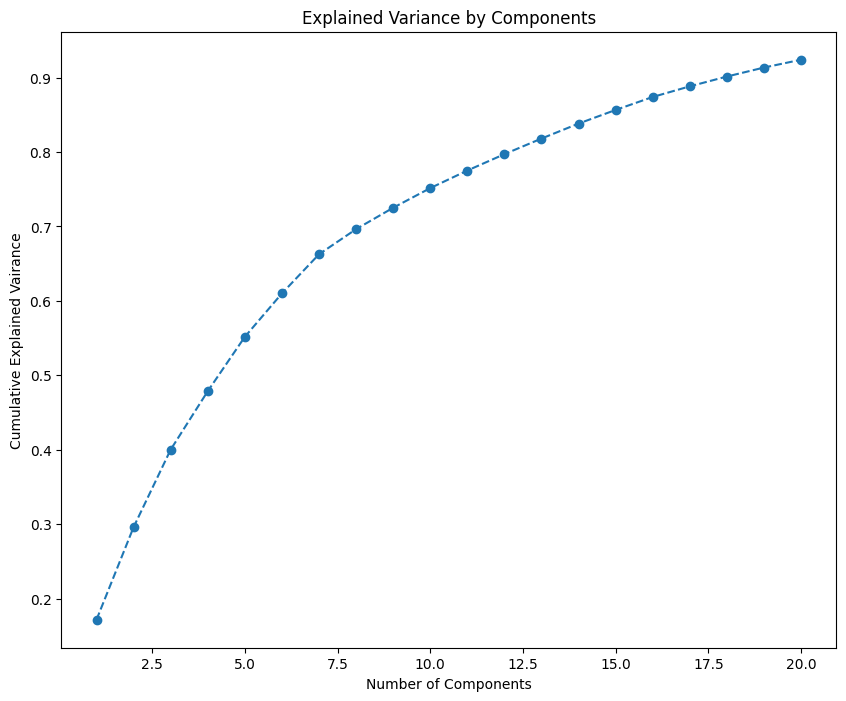

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(outfield_X_train)

explained_variance = pca.explained_variance_ratio_[:20].cumsum()
print(pca.explained_variance_ratio_[:20])

plt.figure(figsize = (10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker = "o", linestyle = "--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Vairance")

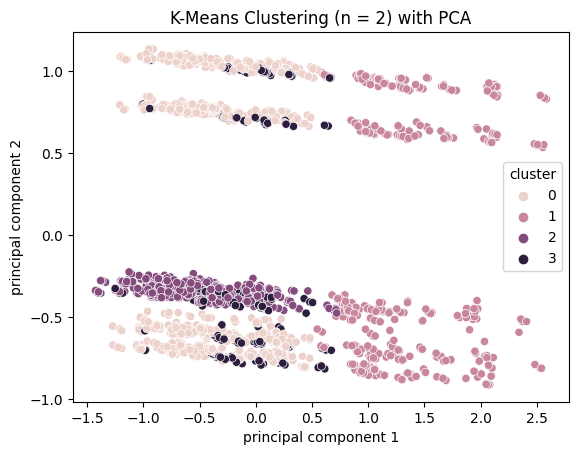

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
outfield_pca2_X_train = pca.fit_transform(outfield_X_train)
outfield_pca2_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca2_X_train, columns = ['principal component 1', 'principal component 2'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=principalDf)
plt.title('K-Means Clustering (n = 2) with PCA')
plt.show()

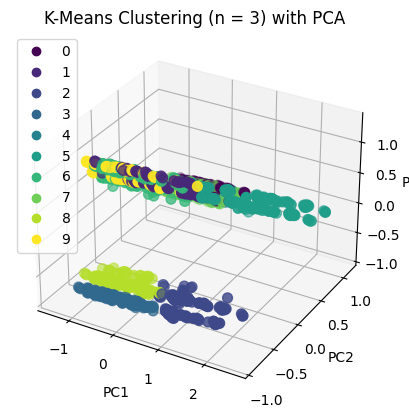

In [8]:
# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
outfield_pca3_X_train = pca.fit_transform(outfield_X_train)
outfield_pca3_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca3_X_train, columns = ['PCA1', 'PCA2', 'PCA3'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PCA1'], principalDf['PCA2'], principalDf['PCA3'], c=principalDf['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(*scatter.legend_elements())
plt.title('K-Means Clustering (n = 3) with PCA')
plt.show()

In [9]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_pca13_X_train = pca.fit_transform(outfield_X_train)
outfield_pca13_X_test = pca.transform(outfield_X_test)

# Training Different Regression Models
In the follow sections, we try to train different regression models on our data. To evaluate the performance of each regression mode, we can use several scores
* **Mean Squared Error (MSE)**
    * Formula: `MSE = Σ(y_true - y_pred)^2 / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average squared difference between predicted and actual values. Lower values indicate better performance.
    * Sensitivity: Sensitive to outliers due to squaring the errors.
* **Normalized Root Mean Squared Error (NRMSE)**
    * Formula: `NRMSE = RMSE / Mean(y_true)`
    * Range: 0 to infinity
    * Interpretation: Provides a relative measure of error, making it easier to compare models for different target variables. Lower NRMSE values indicate better model performance.
        * An NRMSE value of 1 indicates that the average prediction error is equal to the average value of the target variable.
        * An NRMSE value less than 1 suggests that the model's predictions are better than simply predicting the mean.
    * Sensitivity: Like MSE, sensitive to outliers.
* **Mean Absolute Error (MAE)**
    * Formula: `MAE = Σ|y_true - y_pred| / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average absolute difference between predicted and actual values. Less sensitive to outliers than MSE.
    * Sensitivity: Less sensitive to outliers compared to MSE.
* **R-squared (Coefficient of Determination)**
    * Formula: `R^2 = 1 - (SS_res / SS_tot)`
    * Range: -infinity to 1
    * Interpretation: Represents the proportion of variance in the dependent variable explained by the independent variables. Higher values indicate a better fit.
    * Negative R-squared: Indicates the model is performing worse than simply predicting the mean of the dependent variable.

In [10]:
evaluation_metrics = {'Model': [], 'Target': [], 'Mean Square Error': [], 'Mean Absolute Error': [], 'Normalized Root Mean Square Error': [], 'R-Squared Error': []}
def add_evaluation_metrics(model, target, mse, mae, nrmse, r2):
    evaluation_metrics['Model'].append(model)
    evaluation_metrics['Target'].append(target)
    evaluation_metrics['Mean Square Error'].append(mse)
    evaluation_metrics['Mean Absolute Error'].append(mae)
    evaluation_metrics['Normalized Root Mean Square Error'].append(nrmse)
    evaluation_metrics['R-Squared Error'].append(r2)

## Simple Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import numpy as np

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

targets = ['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']
def get_linear_regression_scores(df_X, df_y, X_test, y_test, target):
    model = LinearRegression()
    model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE
    mse = mean_squared_error(y_test[target], y_pred)

    print("Mean Squared Error for ", target, ":", mse)
          
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)
    
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    
    print("Mean Absolute Error for ", target, ":", mae)
          
    # Calculate the R-squared score
    r2 = r2_score(y_test[target], y_pred)

    print("R-squared for ", target, ":", r2, "\n")
    
    return (mse, mae, nrmse, r2)

print(colored('All features:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression', target, mse, mae, nrmse, r2)

print(colored('PCA Components with n = 2:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 2)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 3:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 3)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 13:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 13)', target, mse, mae, nrmse, r2)

All features:
Mean Squared Error for  Total Days : 3030.931202342048
Normalised Root Mean Squared Error for  Total Days : 1.4921604470029501
Mean Absolute Error for  Total Days : 36.93273420479303
R-squared for  Total Days : 0.21897205417730392 

Mean Squared Error for  Total Games Missed : 56.79102307155501
Normalised Root Mean Squared Error for  Total Games Missed : 1.4141519575943684
Mean Absolute Error for  Total Games Missed : 35.702682461873636
R-squared for  Total Games Missed : 0.25110361467390285 

Mean Squared Error for  Injury Count : 1.074276793236826
Normalised Root Mean Squared Error for  Injury Count : 1.0548585824898993
Mean Absolute Error for  Injury Count : 36.57511233660131
R-squared for  Injury Count : 0.1967344458233271 

Mean Squared Error for  Average Injury Cost : 0.018559103602989048
Normalised Root Mean Squared Error for  Average Injury Cost : 1.131771885208982
Mean Absolute Error for  Average Injury Cost : 36.863572729439
R-squared for  Average Injury Cost : 

## K Nearest Neighbours
* Hyperparameters that we can tune: K value, Distance Metrics

### Finding an estimate of the best distance metric
To find a suitable distance metric, we fix and arbitrary K value and iterate through some common metrics. The best metrics will be indicated by the lowest errors achieved.

In [12]:
from sklearn.neighbors import KNeighborsRegressor

metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']  # You can add or remove metrics

# Create empty lists to store performance metrics
mse_scores = []
mae_scores = []
nrmse_scores = []
r2_scores = []

# Loop through each distance metric
for metric in metrics:
    knn_model = KNeighborsRegressor(n_neighbors=5, metric=metric)
    knn_model.fit(outfield_X_train, outfield_y_train['Total Days'])
    y_pred = knn_model.predict(outfield_X_test)

    mse = mean_squared_error(outfield_y_test['Total Days'], y_pred)
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test['Total Days'], y_pred)
    r2 = r2_score(outfield_y_test['Total Days'], y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    nrmse_scores.append(nrmse)
    r2_scores.append(r2)

print(colored('Detailed Results:', 'black', attrs=['bold']))
for i, metric in enumerate(metrics):
    print(f"\nMetric: {metric}")
    print(f"MSE: {mse_scores[i]:.4f}")
    print(f"NRMSE: {nrmse_scores[i]:.4f}")
    print(f"MAE: {mae_scores[i]:.4f}")
    print(f"R-squared: {r2_scores[i]:.4f}")

Detailed Results:

Metric: euclidean
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: manhattan
MSE: 4123.5397
NRMSE: 1.7405
MAE: 41.1512
R-squared: -0.0626

Metric: minkowski
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: cosine
MSE: 3853.0743
NRMSE: 1.6824
MAE: 39.4318
R-squared: 0.0071

Metric: chebyshev
MSE: 3746.1045
NRMSE: 1.6589
MAE: 40.8458
R-squared: 0.0347


### Finding the best K Value for each target
Given a suitable distance metric, to find the best K value we can plot a graph of K against the error (NRMSE). The most suitable value of K will be at the 'elbow point'.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def get_knn_error_rates(df_X, df_y, X_test, y_test, target, k=None):
    # Define a range of k values if k is not provided
    neighbors = np.arange(1, 50) if k is None else [k]

    # Create an empty list to store error values
    error_rates = []

    # Loop over k values
    for i in neighbors:
        knn = KNeighborsRegressor(n_neighbors=i, metric='chebyshev')
        knn.fit(df_X, df_y[target])
        y_pred = knn.predict(X_test)
        error = normalized_root_mean_squared_error(y_test[target], y_pred)
        error_rates.append(error)

    # Create a DataFrame to hold the results
    error_df = pd.DataFrame({'k': neighbors, 'error': error_rates})

    # Find the k value with the lowest error (if k is not provided)
    if k is None:
        best_k = error_df.loc[error_df['error'].idxmin(), 'k']
    else:
        best_k = k

    # Create a line plot using Seaborn
    sns.lineplot(x='k', y='error', data=error_df, marker='o')
    plt.title(f'K-Nearest Neighbors: Error Rate vs. K Value for {target}')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Normalized Root Mean Squared Error')
    plt.show()

    return best_k, error_df

def get_best_knn_error_rates(df_X, df_y, X_test, y_test, target, k):
    knn = KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(df_X, df_y[target])
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(outfield_y_test[target], y_pred)
    mae = mean_absolute_error(outfield_y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test[target], y_pred)
    r2 = r2_score(outfield_y_test[target], y_pred)
    
    print("Mean Squared Error for ", target, ":", mse)          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)    
    print("Mean Absolute Error for ", target, ":", mae)
    print("R-squared for ", target, ":", r2, "\n")

    return mse, mae, nrmse, r2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


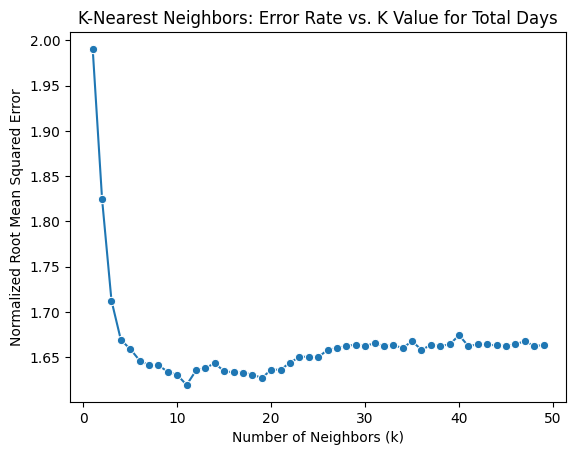

Best K:  11
Smallest Normalised Root MSE:  1.619200373379629
Mean Squared Error for  Total Days : 3568.9973172005257
Normalised Root Mean Squared Error for  Total Days : 1.619200373379629
Mean Absolute Error for  Total Days : 39.639136462665874
R-squared for  Total Days : 0.08032005439585532 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


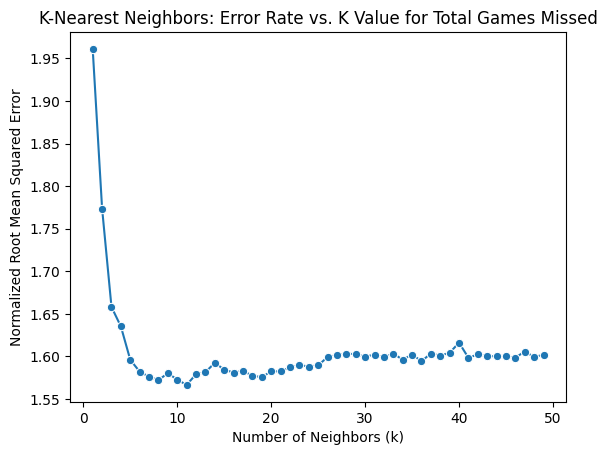

Best K:  11
Smallest Normalised Root MSE:  1.5666261399582908
Mean Squared Error for  Total Games Missed : 69.69767190622805
Normalised Root Mean Squared Error for  Total Games Missed : 1.5666261399582908
Mean Absolute Error for  Total Games Missed : 5.793424440483264
R-squared for  Total Games Missed : 0.08090519006053787 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


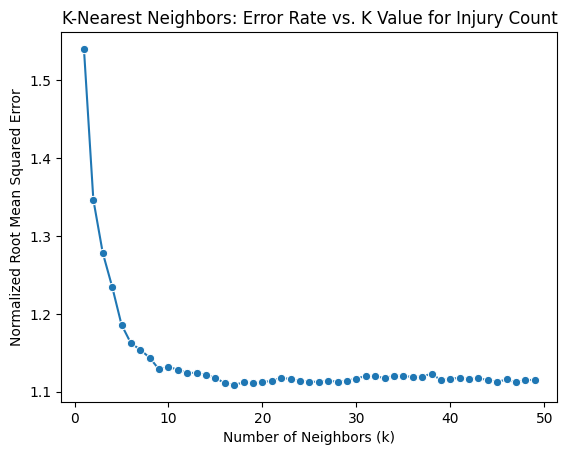

Best K:  17
Smallest Normalised Root MSE:  1.1087868700648518
Mean Squared Error for  Injury Count : 1.1869265968594283
Normalised Root Mean Squared Error for  Injury Count : 1.1087868700648518
Mean Absolute Error for  Injury Count : 0.8459566833269254
R-squared for  Injury Count : 0.11250316808887939 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


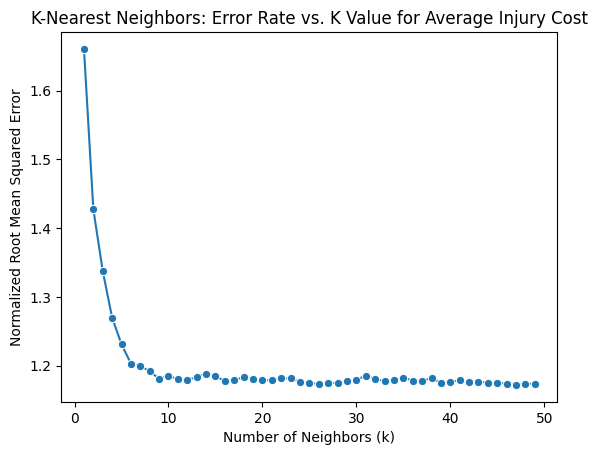

Best K:  47
Smallest Normalised Root MSE:  1.1720869867039876
Mean Squared Error for  Average Injury Cost : 0.0199048487520354
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1720869867039876
Mean Absolute Error for  Average Injury Cost : 0.10886849302368702
R-squared for  Average Injury Cost : 0.07587277975297735 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


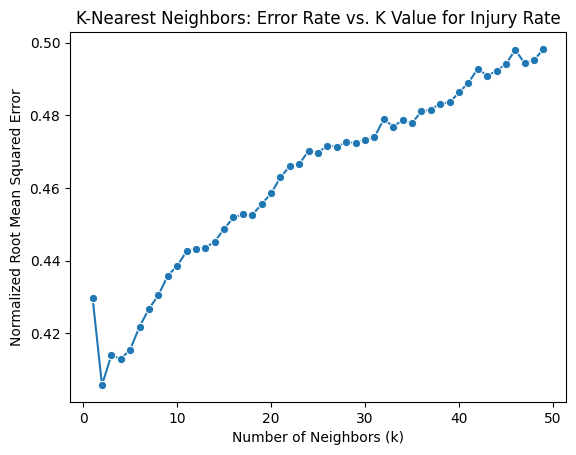

Best K:  2
Smallest Normalised Root MSE:  0.40582242264318896
Mean Squared Error for  Injury Rate : 4.794703809943039e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40582242264318896
Mean Absolute Error for  Injury Rate : 0.0001327048029095531
R-squared for  Injury Rate : 0.6062556873157394 



In [14]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


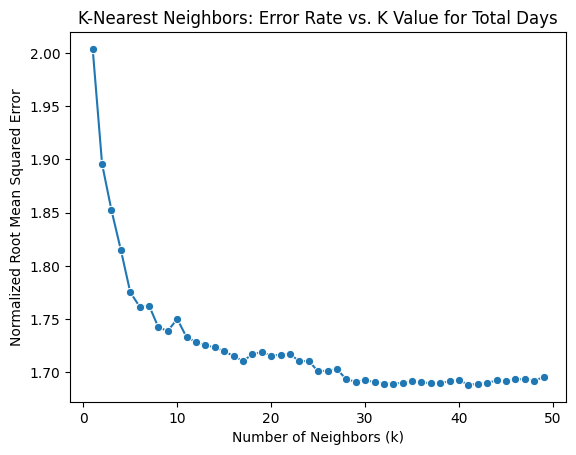

Best K:  41
Smallest Normalised Root MSE:  1.6881448055335362
Mean Squared Error for  Total Days : 3879.398775757246
Normalised Root Mean Squared Error for  Total Days : 1.6881448055335362
Mean Absolute Error for  Total Days : 42.5551835910516
R-squared for  Total Days : 0.00033400477203249235 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


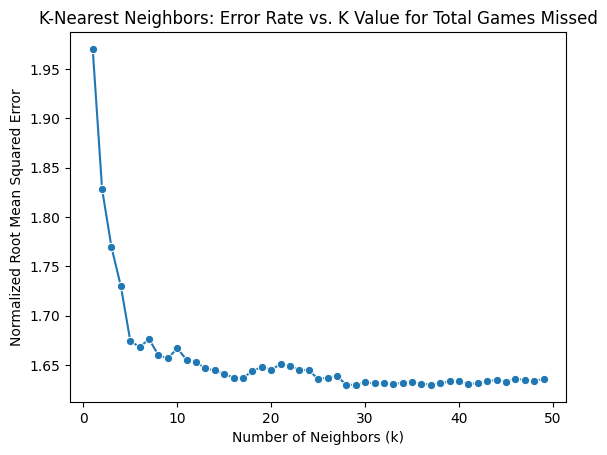

Best K:  29
Smallest Normalised Root MSE:  1.6297244274655263
Mean Squared Error for  Total Games Missed : 75.42509824645937
Normalised Root Mean Squared Error for  Total Games Missed : 1.6297244274655263
Mean Absolute Error for  Total Games Missed : 6.1823304034257385
R-squared for  Total Games Missed : 0.005378308320506786 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


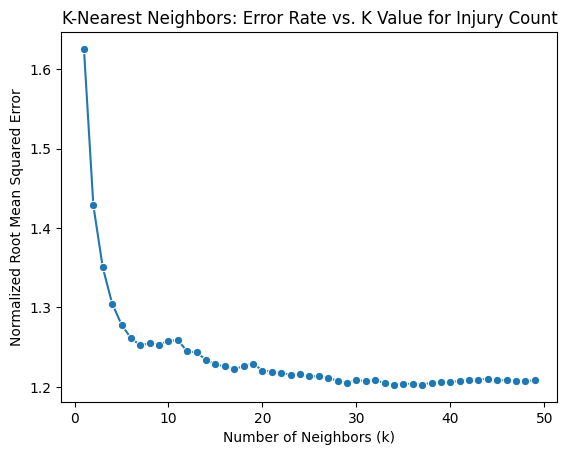

Best K:  34
Smallest Normalised Root MSE:  1.202459055181497
Mean Squared Error for  Injury Count : 1.3959449985299774
Normalised Root Mean Squared Error for  Injury Count : 1.202459055181497
Mean Absolute Error for  Injury Count : 0.9174676406510317
R-squared for  Injury Count : -0.04378549355588812 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


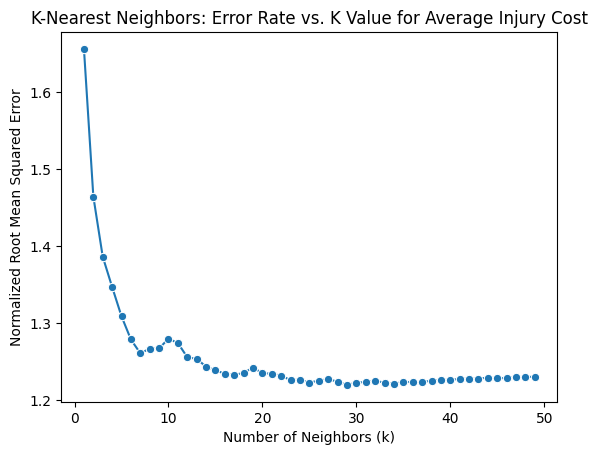

Best K:  29
Smallest Normalised Root MSE:  1.2194908028641758
Mean Squared Error for  Average Injury Cost : 0.02154746838886169
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2194908028641758
Mean Absolute Error for  Average Injury Cost : 0.11562617384118398
R-squared for  Average Injury Cost : -0.0003895188363665092 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


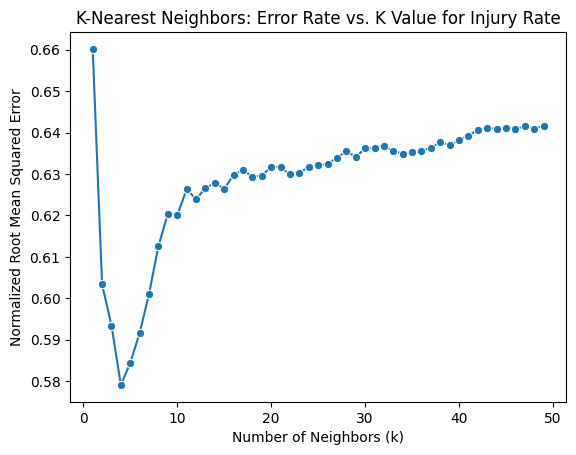

Best K:  4
Smallest Normalised Root MSE:  0.5790663631466039
Mean Squared Error for  Injury Rate : 9.762170362968266e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5790663631466039
Mean Absolute Error for  Injury Rate : 0.00023100448855155561
R-squared for  Injury Rate : 0.19832398157681774 



In [15]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 2)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


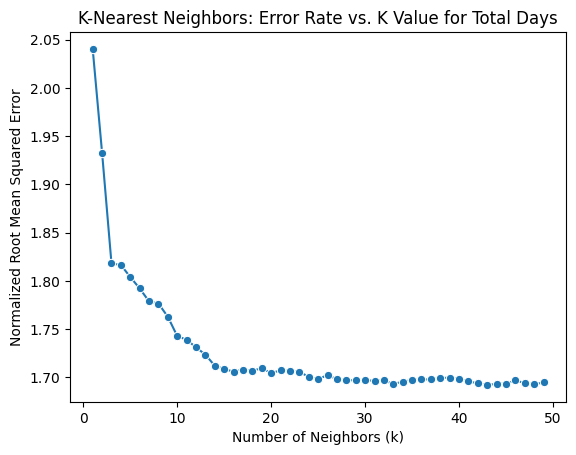

Best K:  43
Smallest Normalised Root MSE:  1.691991297626012
Mean Squared Error for  Total Days : 3897.0975855759043
Normalised Root Mean Squared Error for  Total Days : 1.691991297626012
Mean Absolute Error for  Total Days : 42.36687439833815
R-squared for  Total Days : -0.00422672727806872 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


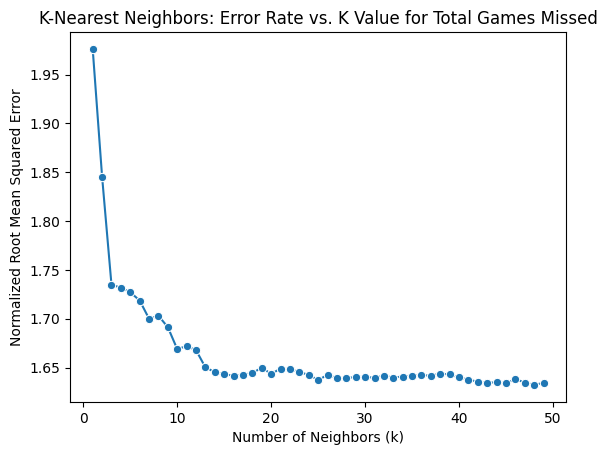

Best K:  48
Smallest Normalised Root MSE:  1.6322228164588681
Mean Squared Error for  Total Games Missed : 75.65653084150327
Normalised Root Mean Squared Error for  Total Games Missed : 1.6322228164588681
Mean Absolute Error for  Total Games Missed : 6.17687908496732
R-squared for  Total Games Missed : 0.0023264345471353254 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


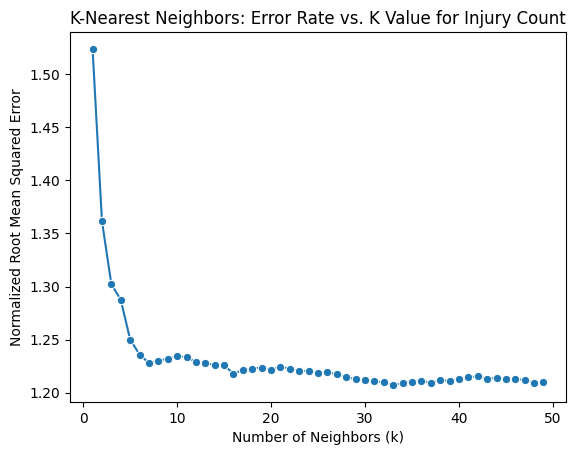

Best K:  33
Smallest Normalised Root MSE:  1.2072991142761313
Mean Squared Error for  Injury Count : 1.4072053471934638
Normalised Root Mean Squared Error for  Injury Count : 1.2072991142761313
Mean Absolute Error for  Injury Count : 0.9162870535419556
R-squared for  Injury Count : -0.0522051580840075 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


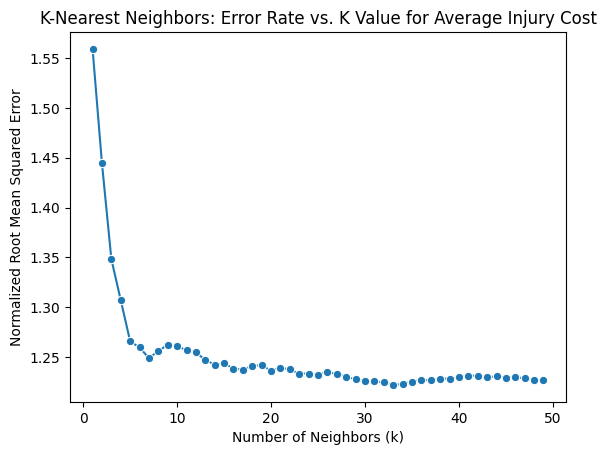

Best K:  33
Smallest Normalised Root MSE:  1.2218618647291715
Mean Squared Error for  Average Injury Cost : 0.021631339539182677
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2218618647291715
Mean Absolute Error for  Average Injury Cost : 0.11551528355449925
R-squared for  Average Injury Cost : -0.004283424988109186 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


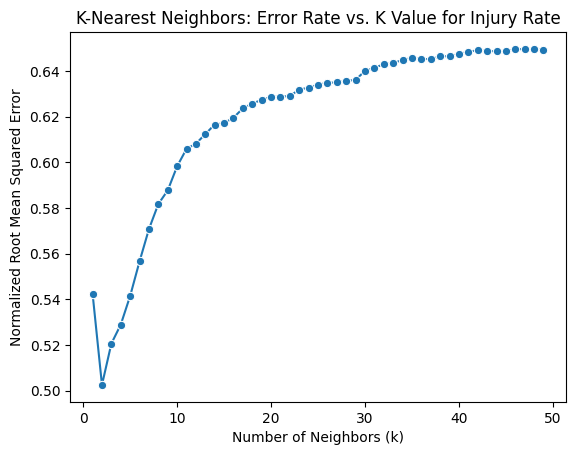

Best K:  2
Smallest Normalised Root MSE:  0.5025377677928661
Mean Squared Error for  Injury Rate : 7.352366006518584e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5025377677928661
Mean Absolute Error for  Injury Rate : 0.0001560032889197848
R-squared for  Injury Rate : 0.3962187416381465 



In [16]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 3)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


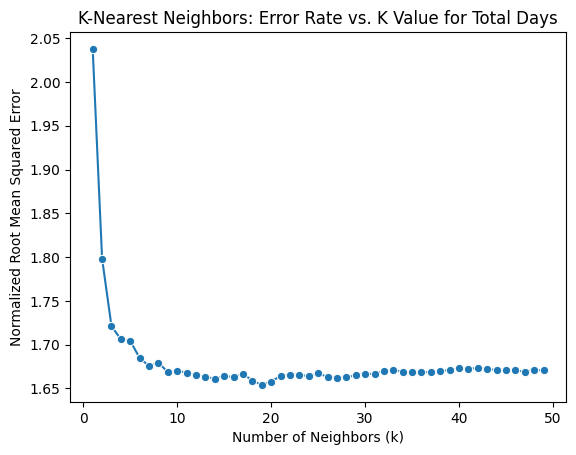

Best K:  19
Smallest Normalised Root MSE:  1.6540233174204415
Mean Squared Error for  Total Days : 3724.1596147230825
Normalised Root Mean Squared Error for  Total Days : 1.6540233174204415
Mean Absolute Error for  Total Days : 40.210067652792105
R-squared for  Total Days : 0.040336932901863576 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


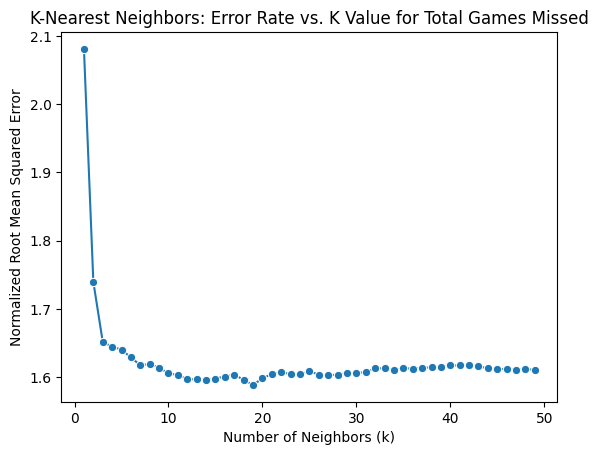

Best K:  19
Smallest Normalised Root MSE:  1.5887308382102343
Mean Squared Error for  Total Games Missed : 71.67838067821774
Normalised Root Mean Squared Error for  Total Games Missed : 1.5887308382102343
Mean Absolute Error for  Total Games Missed : 5.866299736268776
R-squared for  Total Games Missed : 0.054785821901633724 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


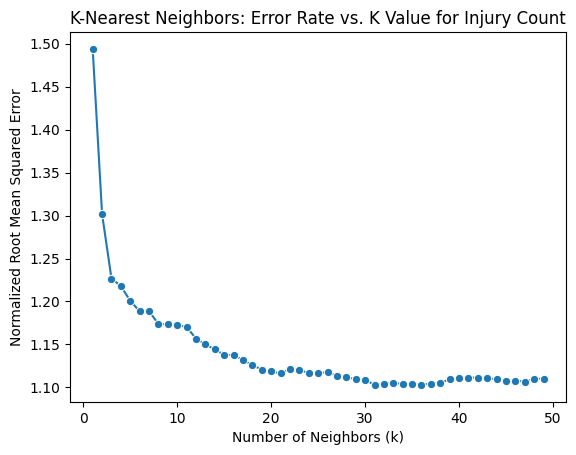

Best K:  31
Smallest Normalised Root MSE:  1.1028930656299514
Mean Squared Error for  Injury Count : 1.1743418144226128
Normalised Root Mean Squared Error for  Injury Count : 1.1028930656299514
Mean Absolute Error for  Injury Count : 0.8410288846721483
R-squared for  Injury Count : 0.1219131472506213 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


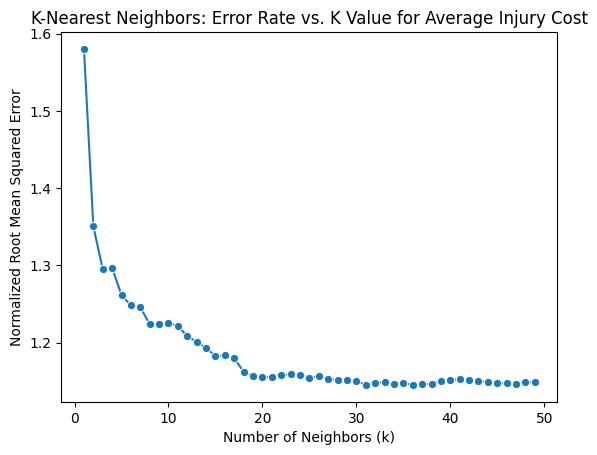

Best K:  31
Smallest Normalised Root MSE:  1.1451792473391946
Mean Squared Error for  Average Injury Cost : 0.01900142326325836
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1451792473391946
Mean Absolute Error for  Average Injury Cost : 0.10741724646847986
R-squared for  Average Injury Cost : 0.11781633310745643 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


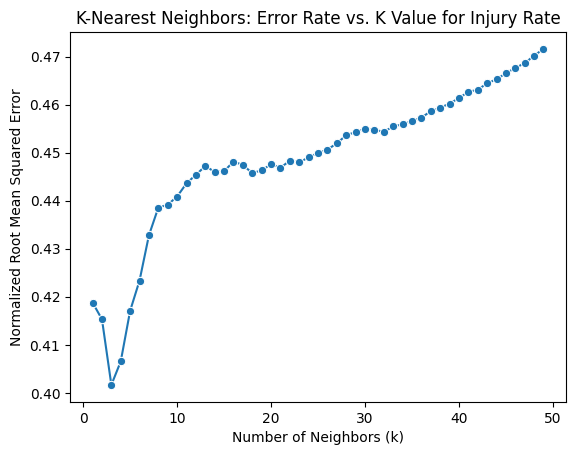

Best K:  3
Smallest Normalised Root MSE:  0.40164519262572795
Mean Squared Error for  Injury Rate : 4.6965056818246296e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40164519262572795
Mean Absolute Error for  Injury Rate : 0.00013953708689683997
R-squared for  Injury Rate : 0.6143197838679983 



In [17]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 13)', target, mse, mae, nrmse, r2)

## Decision Tree

In [18]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def get_decision_tree_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a decision tree model
    dt_model = DecisionTreeRegressor()

    # Fit the model to the training data
    dt_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = dt_model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Decision Tree Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [19]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5606.745098039216
MAE: 45.59477124183007
NRMSE: 2.0294711901667366
R-squared: -0.44477862225618914 

Decision Tree Errors for Total Games Missed:
MSE: 106.77124183006536
MAE: 6.531590413943355
NRMSE: 1.9390248718267584
R-squared: -0.4079795139905569 

Decision Tree Errors for Injury Count:
MSE: 2.0631808278867103
MAE: 1.0217864923747277
NRMSE: 1.4618566590867803
R-squared: -0.5426956083503096 

Decision Tree Errors for Average Injury Cost:
MSE: 0.038709586056644874
MAE: 0.12712418300653594
NRMSE: 1.634517846437812
R-squared: -0.7971793006355881 

Decision Tree Errors for Injury Rate:
MSE: 3.9046208815933184e-11
MAE: 2.916641785737444e-07
NRMSE: 0.01158096058141686
R-squared: 0.9996793498980839 



In [20]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6262.176470588235
MAE: 48.19825708061002
NRMSE: 2.1448164682812
R-squared: -0.6136739829077771 

Decision Tree Errors for Total Games Missed:
MSE: 119.40087145969498
MAE: 6.877995642701525
NRMSE: 2.050500979643197
R-squared: -0.5745249196917335 

Decision Tree Errors for Injury Count:
MSE: 2.8453159041394334
MAE: 1.198257080610022
NRMSE: 1.7167275998670464
R-squared: -1.1275189699107755 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03598409586056645
MAE: 0.13596949891067536
NRMSE: 1.575925564648128
R-squared: -0.6706423090668923 

Decision Tree Errors for Injury Rate:
MSE: 1.5421420594954065e-07
MAE: 0.0002492578711915175
NRMSE: 0.7278088599397444
R-squared: -0.26641746674383704 



In [21]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5765.99128540305
MAE: 46.41394335511983
NRMSE: 2.058090535072483
R-squared: -0.4858141041901787 

Decision Tree Errors for Total Games Missed:
MSE: 123.77342047930283
MAE: 6.915032679738562
NRMSE: 2.087708835680524
R-squared: -0.6321851972908814 

Decision Tree Errors for Injury Count:
MSE: 2.326797385620915
MAE: 1.0631808278867103
NRMSE: 1.5524421556451489
R-squared: -0.7398087747815529 

Decision Tree Errors for Average Injury Cost:
MSE: 0.0388677559912854
MAE: 0.14089324618736387
NRMSE: 1.6378538162987009
R-squared: -0.8045226943908939 

Decision Tree Errors for Injury Rate:
MSE: 1.0013513848687543e-07
MAE: 0.00015939246180738956
NRMSE: 0.5864735072483301
R-squared: 0.17768348490484953 



In [22]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5554.616557734204
MAE: 46.3202614379085
NRMSE: 2.020014685425017
R-squared: -0.4313458374005983 

Decision Tree Errors for Total Games Missed:
MSE: 109.88888888888889
MAE: 6.664488017429194
NRMSE: 1.9671302817726959
R-squared: -0.4490915504850168 

Decision Tree Errors for Injury Count:
MSE: 1.877995642701525
MAE: 0.9498910675381264
NRMSE: 1.3947084553622033
R-squared: -0.40422768151844446 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03387843137254902
MAE: 0.12636165577342048
NRMSE: 1.5291216946269413
R-squared: -0.5728821153409571 

Decision Tree Errors for Injury Rate:
MSE: 1.0631712850563273e-08
MAE: 2.9573438456349295e-05
NRMSE: 0.1910982747801329
R-squared: 0.9126916565665568 



## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

def get_random_forest_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a random forest model
    rf_model = RandomForestRegressor(n_estimators=100)
      # Adjust n_estimators as needed

    # Fit the model to the training data
    rf_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Random Forest Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [24]:
for target in targets:
    mse, mae, nrmse, r2 = get_random_forest_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest', target, mse, mae, nrmse, r2)

Random Forest Errors for Total Days:
MSE: 3028.1376244008716
MAE: 36.49272331154685
NRMSE: 1.4914726340533788
R-squared: 0.21969191955702838 

Random Forest Errors for Total Games Missed:
MSE: 59.27237734204793
MAE: 5.286928104575163
NRMSE: 1.444715745793712
R-squared: 0.21838229458878577 

Random Forest Errors for Injury Count:
MSE: 1.0390579520697167
MAE: 0.7905446623093683
NRMSE: 1.0374233742248702
R-squared: 0.22306851740121103 

Random Forest Errors for Average Injury Cost:
MSE: 0.01812830664488017
MAE: 0.10330087145969498
NRMSE: 1.1185593246478704
R-squared: 0.15835272921600807 

Random Forest Errors for Injury Rate:
MSE: 4.797361627582394e-11
MAE: 3.9337287815579773e-07
NRMSE: 0.01283678820026639
R-squared: 0.9996060374255376 



In [25]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6287.949891067538
MAE: 48.74291938997821
NRMSE: 2.1492256776900542
R-squared: -0.6203154275034908 

Decision Tree Errors for Total Games Missed:
MSE: 128.37037037037038
MAE: 7.163398692810458
NRMSE: 2.126124196105741
R-squared: -0.6928046221709026 

Decision Tree Errors for Injury Count:
MSE: 2.79520697167756
MAE: 1.1830065359477124
NRMSE: 1.7015437850528716
R-squared: -1.0900511779445061 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03664161220043573
MAE: 0.13601307189542483
NRMSE: 1.590258370407209
R-squared: -0.7011689789753115 

Decision Tree Errors for Injury Rate:
MSE: 1.445789859794067e-07
MAE: 0.0002392660327168077
NRMSE: 0.7047056189638011
R-squared: -0.1872923900950021 



In [26]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5904.5446623093685
MAE: 46.98039215686274
NRMSE: 2.0826710996328295
R-squared: -0.5215173426102129 

Decision Tree Errors for Total Games Missed:
MSE: 131.11328976034858
MAE: 7.004357298474946
NRMSE: 2.1487188315314953
R-squared: -0.728975170002157 

Decision Tree Errors for Injury Count:
MSE: 2.5642701525054465
MAE: 1.1002178649237473
NRMSE: 1.6297389019866133
R-squared: -0.9173735280130035 

Decision Tree Errors for Average Injury Cost:
MSE: 0.04072984749455338
MAE: 0.14104575163398694
NRMSE: 1.6766283106784479
R-squared: -0.8909744663283556 

Decision Tree Errors for Injury Rate:
MSE: 1.0170826141073179e-07
MAE: 0.0001588645961518695
NRMSE: 0.5910623040840824
R-squared: 0.164764893288467 



In [27]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5746.845315904139
MAE: 47.04575163398693
NRMSE: 2.0546707498671695
R-squared: -0.4808804596333627 

Decision Tree Errors for Total Games Missed:
MSE: 114.29847494553377
MAE: 6.742919389978214
NRMSE: 2.0062102766306933
R-squared: -0.5072402310334352 

Decision Tree Errors for Injury Count:
MSE: 1.8823529411764706
MAE: 0.9498910675381264
NRMSE: 1.3963255091869013
R-squared: -0.4074857503850766 

Decision Tree Errors for Average Injury Cost:
MSE: 0.030132244008714597
MAE: 0.11823529411764706
NRMSE: 1.4421025374455132
R-squared: -0.3989569698554474 

Decision Tree Errors for Injury Rate:
MSE: 1.2244059674007252e-08
MAE: 3.1369789076744284e-05
NRMSE: 0.20507742982016489
R-squared: 0.8994509556396492 



## Neural Network
Hyperparameter to tune
* Loss function
* Hidden layers (Neurons per hidden layer)
* Batch size
* Epoch
* Optimizer
* Activation function

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

results = {
    "Model": [],
    "Target": [],
    "Loss Function": [],
    "Activation Function": [],
    "Optimizer": [],
    "Hidden Layers": [],
    "Epochs": [],
    "Batch Size": [],
    "Neurons per hidden layer": [],
    "MSE": [],
    "MAE": [],
    "NRMSE": [],
    "R-squared": []
}

hyperparameter_grid = {
    'loss_functions': ['mean_squared_error', 'mean_absolute_error', 'huber', 'log_cosh'],
    'activation_functions': ['relu', 'sigmoid', 'tanh'],
    'optimizers': ['SGD', 'adam'],
    'hidden_layers': [1, 2],  # Number of hidden layers
    'epochs': [50, 100, 200],  # Training epochs
    'batch_size': [64, 128],  # Batch size
    'neurons_per_layer': [32]
}

def use_optimised_nn_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
      Input(shape=(df_X.shape[1],)),
      Dense(32, activation='relu'),
      Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=50, batch_size=128, verbose=0)

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2
    

def get_nn_error_rates(model_name, df_X, df_y, X_test, y_test, target):
    # Loop through different loss functions
    for loss_func in hyperparameter_grid['loss_functions']:
        for activation_function in hyperparameter_grid['activation_functions']:
            for optimizer in hyperparameter_grid['optimizers']:
                for hidden_layers in hyperparameter_grid['hidden_layers']:
                    for epochs in hyperparameter_grid['epochs']:
                        for batch_size in hyperparameter_grid['batch_size']:
                            for neurons_per_layer in hyperparameter_grid['neurons_per_layer']:
                                print(f"Loss function: {loss_func}, Activation Function: {activation_function}, Optimizer: {optimizer}, Hidden layers: {hidden_layers}, Epochs: {epochs}, Batch size: {batch_size}, Neurons per layer: {neurons_per_layer}")

                                # Create the model
                                model = Sequential()
                                model.add(Input(shape=(df_X.shape[1],)))

                                for _ in range(hidden_layers):
                                    model.add(Dense(neurons_per_layer, activation='relu'))

                                model.add(Dense(1)) # output layer

                                model.compile(loss=loss_func, optimizer='adam')

                                model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)

                                # Evaluate on validation set (optional)
                                val_loss = model.evaluate(df_X, df_y, verbose=0)
                                print(f"Training Loss: {val_loss}")

                                # Evaluate on test set
                                y_pred = model.predict(X_test)

                                mse = mean_squared_error(y_test[target], y_pred)
                                mae = mean_absolute_error(y_test[target], y_pred)
                                nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
                                r2 = r2_score(y_test[target], y_pred)

                                # Print performance metrics
                                print(f"Test Set Performance ({loss_func}):")
                                print("MSE:", mse)
                                print("MAE:", mae)
                                print("NRMSE:", nrmse)
                                print("R-squared:", r2, '\n')

                                # Prepare data for visualization (optional)
                                results['Model'].append(model_name)
                                results['Target'].append(target)
                                results['Loss Function'].append(loss_func)
                                results['Activation Function'].append(activation_function)
                                results['Optimizer'].append(optimizer)
                                results['Hidden Layers'].append(hidden_layers)
                                results['Epochs'].append(epochs)
                                results['Batch Size'].append(batch_size)
                                results['Neurons per hidden layer'].append(neurons_per_layer)

                                results['MSE'].append(mse)
                                results['MAE'].append(mae)
                                results['NRMSE'].append(nrmse)
                                results['R-squared'].append(r2)

    return pd.DataFrame(results)
    
def create_nn_performance_chart(results_df, x_metric, y_metric):
    # Create Seaborn bar plot
    sns.barplot(x=x_metric, y=y_metric, data=results_df)
    plt.title(f'Neural Network Performance by {y_metric} against {x_metric}')
    plt.xlabel(f'{x_metric}')
    plt.xticks(rotation=90)
    plt.ylabel('Performance Metric')
    plt.show()

In [29]:
def print_overall_nn_min_stats(df, title):
    print(colored(title, 'black', attrs=['bold']))
    print(df.idxmin(), '\n')
    
def print_nn_model_by_index(df, index):
    print(df.loc[[index]])

Using the optimised (benchmark) NN model, get the performance across all targets to compare with other models.

In [38]:
for target in targets:
    mse, mae, nrmse, r2 = use_optimised_nn_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Neural Network', target, mse, mae, nrmse, r2)

Training Loss: 8.049013137817383
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Days:
MSE: 5228.469634754993
MAE: 36.84144287384298
NRMSE: 1.9598136564828263
R-squared: -0.3473024051069147 

Training Loss: 8.053079605102539
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Games Missed:
MSE: 102.32370157033031
MAE: 5.290953938851299
NRMSE: 1.898210424207622
R-squared: -0.3493303359345248 

Training Loss: 8.0516996383667
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Injury Count:
MSE: 1.9691704230808194
MAE: 0.9327669804307078
NRMSE: 1.4281630599955701
R-squared: -0.47240150873819053 

Training Loss: 8.05151653289795
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Average Injury Cost:
MSE: 0.031186300591535498
MAE: 0.12277140149087817
NRMSE: 1.4671088384250945
R-squared: -0.44789390939213924 

Training Loss: 8.048084259033203
15/15 

In [54]:
for target in targets:
    mse, mae, nrmse, r2 = use_optimised_nn_model(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Neural Network (PCA n = 2)', target, mse, mae, nrmse, r2)

Training Loss: 8.069917678833008
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Days:
MSE: 5238.195287069139
MAE: 36.889127116214105
NRMSE: 1.9616355672937336
R-squared: -0.34980856764957946 

Training Loss: 8.069866180419922
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Games Missed:
MSE: 103.71041396848132
MAE: 5.328294681275592
NRMSE: 1.9110296124173833
R-squared: -0.3676167454107844 

Training Loss: 8.069782257080078
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Injury Count:
MSE: 2.227127234063712
MAE: 0.9779482874572927
NRMSE: 1.518828220706612
R-squared: -0.6652827308145768 

Training Loss: 8.069900512695312
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Average Injury Cost:
MSE: 0.029986528614829765
MAE: 0.12138286371068108
NRMSE: 1.4386114067617208
R-squared: -0.39219180607171245 

Training Loss: 8.069843292236328
15/

In [55]:
for target in targets:
    mse, mae, nrmse, r2 = use_optimised_nn_model(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Neural Network (PCA n = 3)', target, mse, mae, nrmse, r2)

Training Loss: 8.069554328918457
15/15 [==============================] - 0s 2ms/step
Neural Network Performance for Total Days:
MSE: 5238.810627157215
MAE: 36.89047612051108
NRMSE: 1.9617507823143114
R-squared: -0.3499671320553308 

Training Loss: 8.070457458496094
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Games Missed:
MSE: 103.61655068738393
MAE: 5.327463264993041
NRMSE: 1.9101646264085912
R-squared: -0.3663789816212484 

Training Loss: 8.070130348205566
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Injury Count:
MSE: 2.2138998800320553
MAE: 0.9749252897867839
NRMSE: 1.5143111915620617
R-squared: -0.6553922836473101 

Training Loss: 8.070326805114746
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Average Injury Cost:
MSE: 0.03123091482084672
MAE: 0.12363317365336084
NRMSE: 1.4681578653455738
R-squared: -0.4499652249911903 

Training Loss: 8.070008277893066
15/15

In [56]:
for target in targets:
    mse, mae, nrmse, r2 = use_optimised_nn_model(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Neural Network (PCA n = 13)', target, mse, mae, nrmse, r2)

Training Loss: 8.060028076171875
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Days:
MSE: 5231.553820932003
MAE: 36.85572425062993
NRMSE: 1.960391601799232
R-squared: -0.34809715610373826 

Training Loss: 8.060293197631836
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Total Games Missed:
MSE: 102.75544073687087
MAE: 5.297126842859507
NRMSE: 1.902210812781765
R-squared: -0.35502362835538026 

Training Loss: 8.060094833374023
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Injury Count:
MSE: 2.029069026403793
MAE: 0.9434798666821845
NRMSE: 1.4497214153762672
R-squared: -0.5171893000183756 

Training Loss: 8.059569358825684
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Average Injury Cost:
MSE: 0.02786483816820454
MAE: 0.11672940404229434
NRMSE: 1.3867834999392565
R-squared: -0.29368757129505085 

Training Loss: 8.059664726257324
15/15

In [30]:
narrowed_targets = ['Total Days', 'Average Injury Cost', 'Injury Rate']
for target in narrowed_targets:
    nn_results_df = get_nn_error_rates('Neural Network', outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    nn_results_df.to_csv(f'nn_results_{target}.csv', index=False)

Loss function: mean_squared_error, Activation Function: relu, Optimizer: SGD, Hidden layers: 1, Epochs: 50, Batch size: 64, Neurons per layer: 32


I0000 00:00:1724220239.637847     179 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Loss: 739.6415405273438
15/15 [==============================] - 0s 2ms/step
Test Set Performance (mean_squared_error):
MSE: 4393.23290817802
MAE: 35.08698426711339
NRMSE: 1.7964684672720426
R-squared: -0.13207375711582525 

Loss function: mean_squared_error, Activation Function: relu, Optimizer: SGD, Hidden layers: 1, Epochs: 50, Batch size: 128, Neurons per layer: 32
Training Loss: 740.123046875
15/15 [==============================] - 0s 2ms/step
Test Set Performance (mean_squared_error):
MSE: 4404.118025523956
MAE: 35.25324463055414
NRMSE: 1.7986926462249395
R-squared: -0.13487869733821167 

Loss function: mean_squared_error, Activation Function: relu, Optimizer: SGD, Hidden layers: 1, Epochs: 100, Batch size: 64, Neurons per layer: 32
Training Loss: 741.3693237304688
15/15 [==============================] - 0s 2ms/step
Test Set Performance (mean_squared_error):
MSE: 4391.075681961675
MAE: 35.24249156069392
NRMSE: 1.7960273496703705
R-squared: -0.13151787054237718 

Loss f

In [ ]:
pca2_nn_results_df = get_nn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
pca2_nn_results_df.to_csv('pca2_nn_results.csv', index=False)

In [ ]:
pca3_nn_results_df = get_nn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
pca3_nn_results_df.to_csv('pca3_nn_results.csv', index=False)

In [ ]:
pca13_nn_results_df = get_nn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
pca13_nn_results_df.to_csv('pca13_nn_results.csv', index=False)

### Hyperparameter tuning vs Performance

### Predicting Total Days

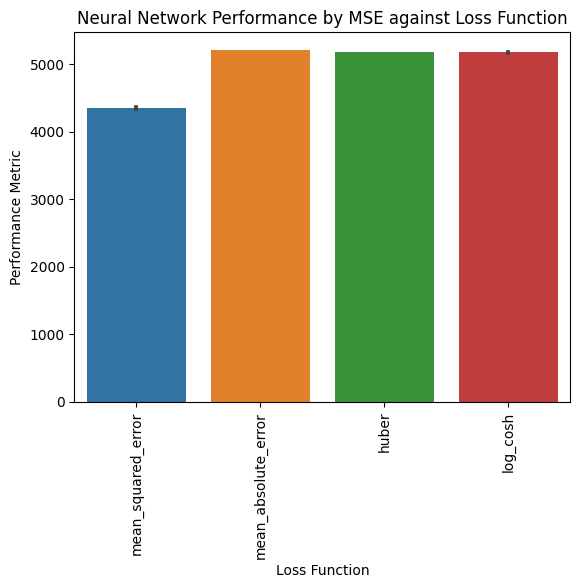

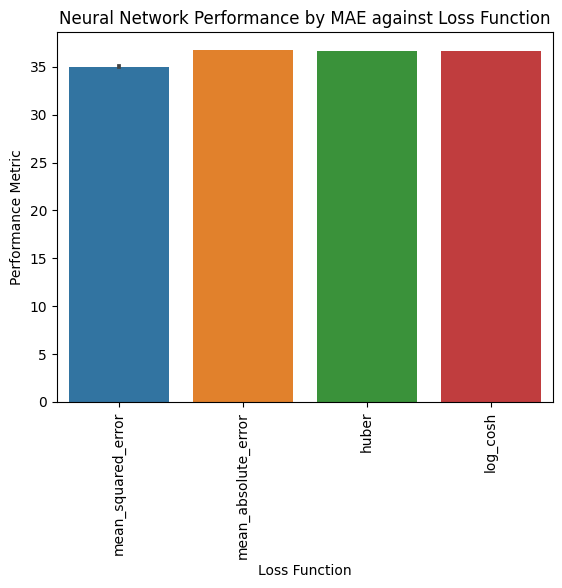

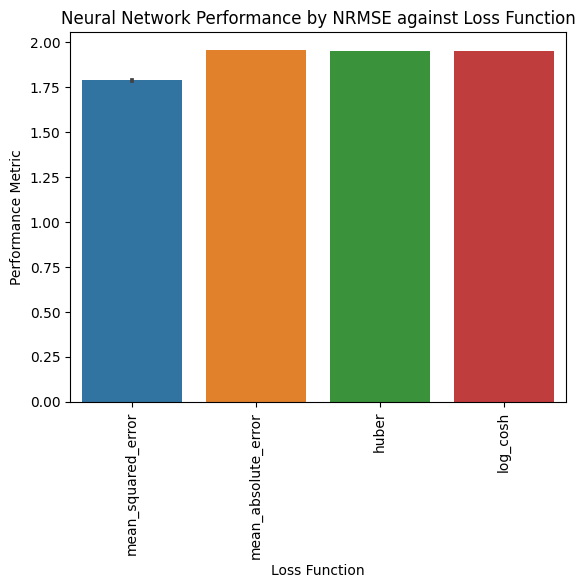

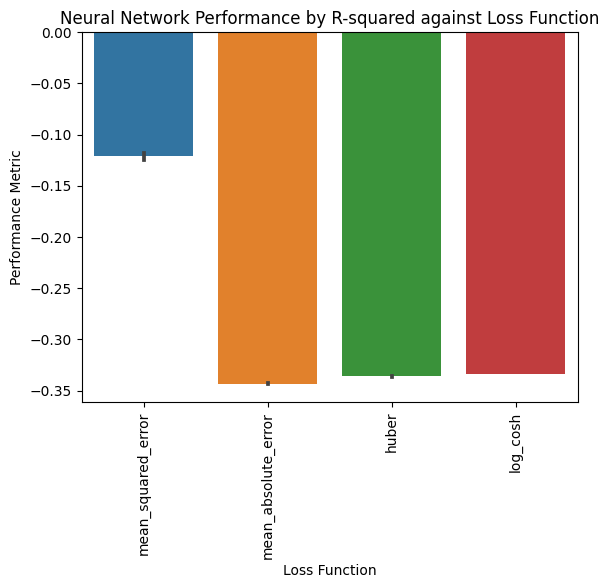

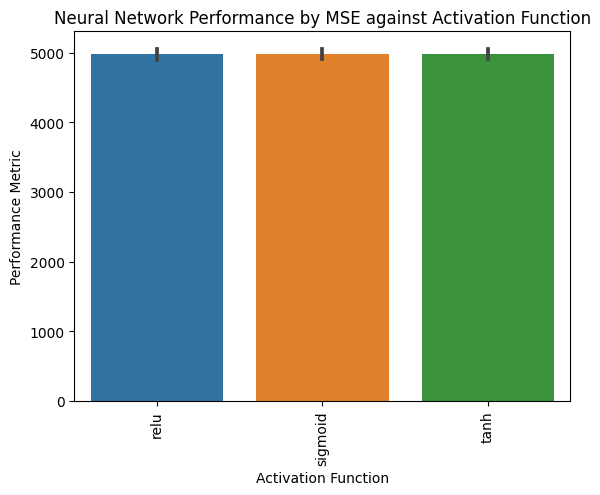

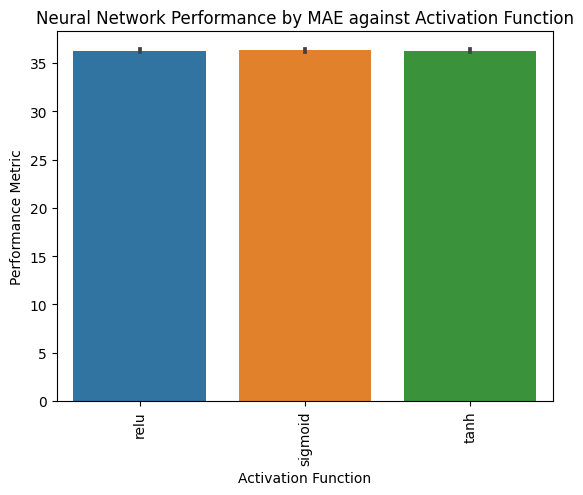

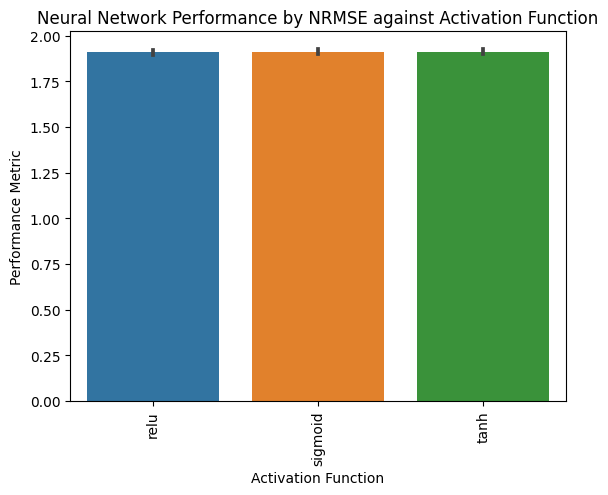

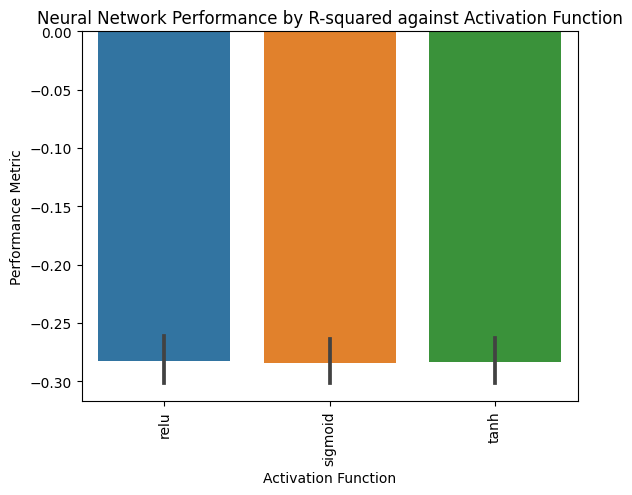

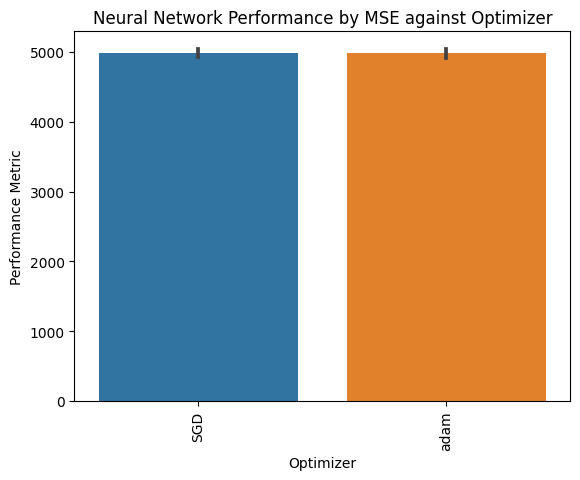

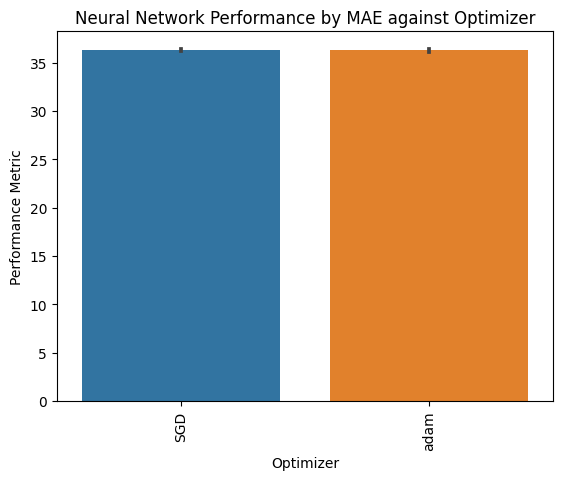

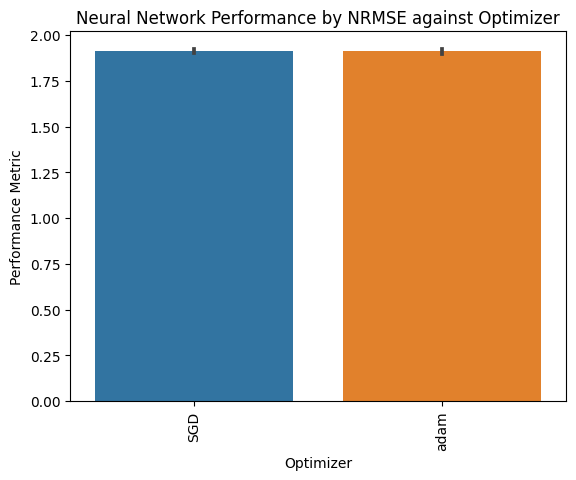

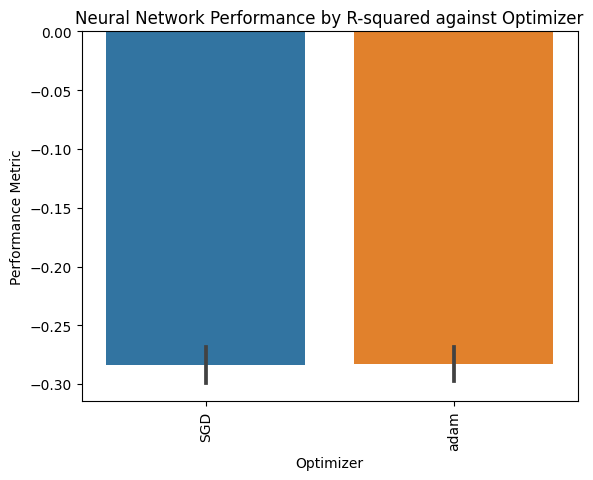

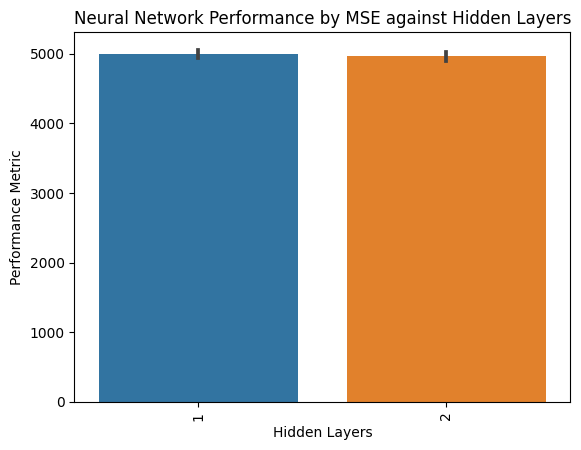

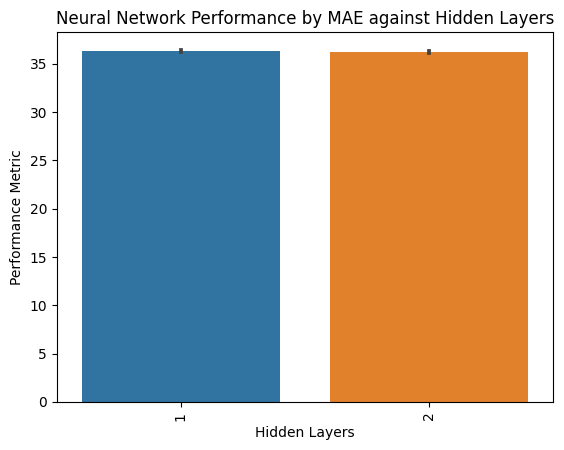

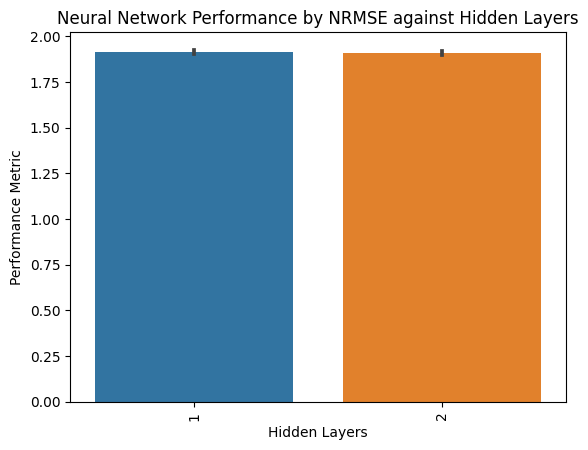

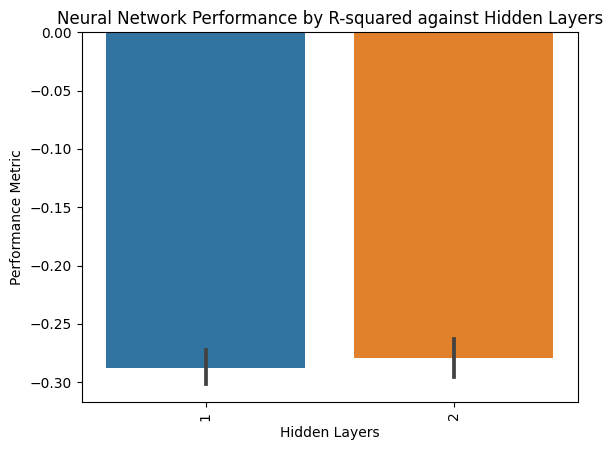

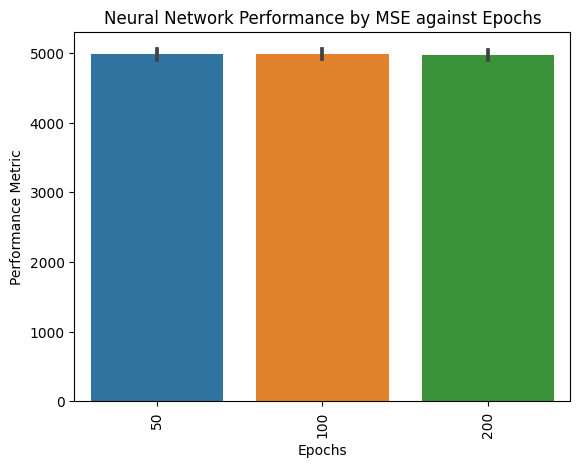

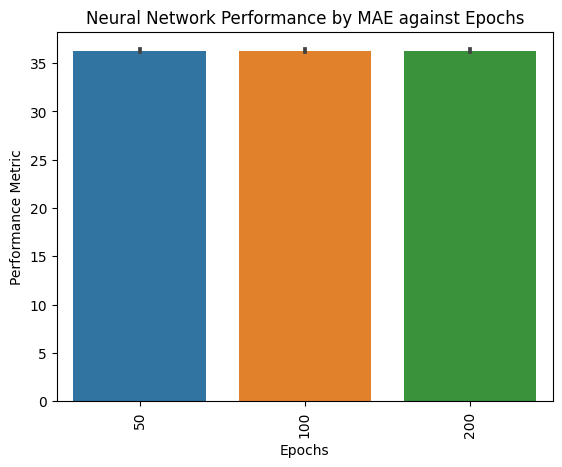

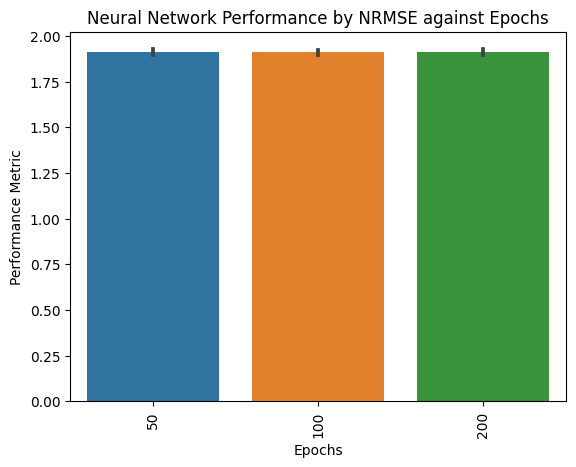

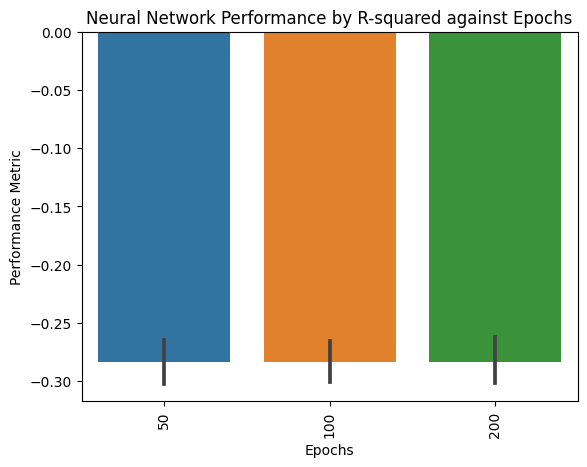

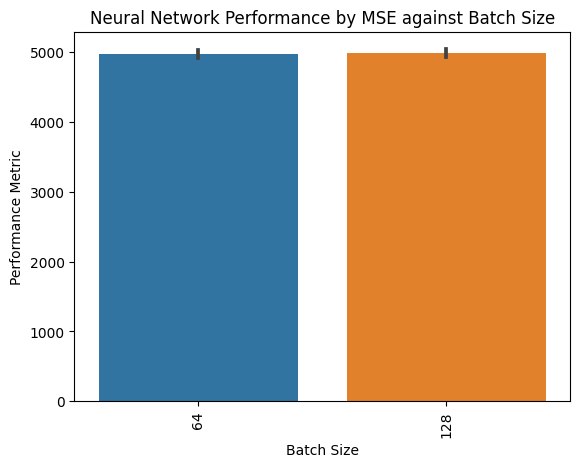

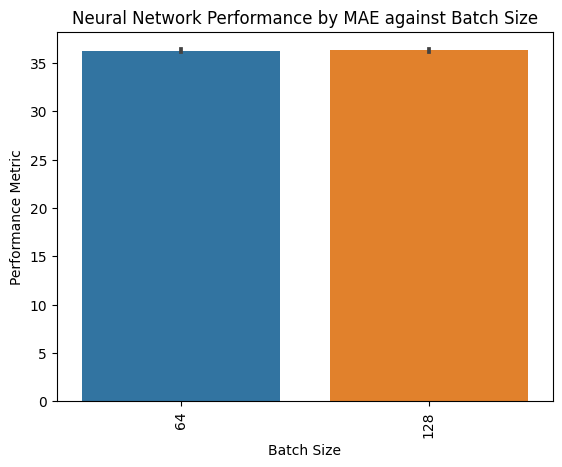

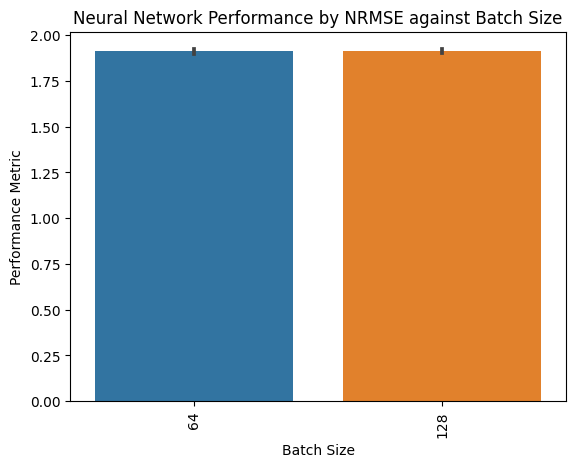

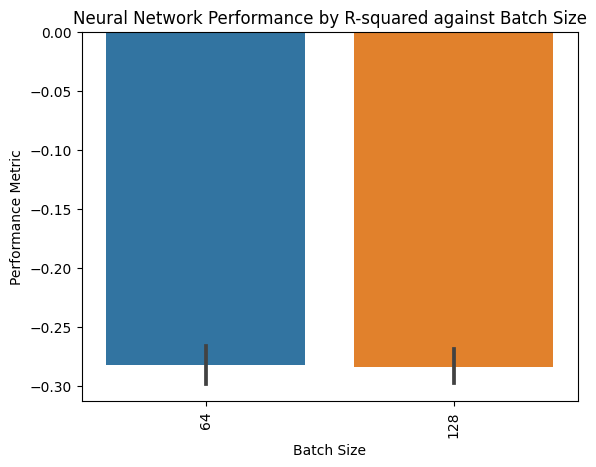

In [50]:
y_metrics = ["MSE", "MAE", "NRMSE", "R-squared"]
x_metrics = ["Loss Function", "Activation Function", "Optimizer", "Hidden Layers", "Epochs", "Batch Size"]

nn_results_total_days_df = nn_results_df[nn_results_df["Target"] == "Total Days"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_total_days_df, x_metric, y_metric)

In [51]:
print_overall_nn_min_stats(nn_results_total_days_df, 'Neural Network Total Days Performance')

Neural Network Total Days Performance
Model                         0
Target                        0
Loss Function               144
Activation Function           0
Optimizer                     0
Hidden Layers                 0
Epochs                        0
Batch Size                    0
Neurons per hidden layer      0
MSE                          18
MAE                          20
NRMSE                        18
R-squared                   101
dtype: int64 



In [52]:
nn_results_total_days_df.loc[[18]]

Model      Target       Loss Function Activation Function  \
18  Neural Network  Total Days  mean_squared_error                relu   

   Optimizer  Hidden Layers  Epochs  Batch Size  Neurons per hidden layer  \
18      adam              2      50          64                        32   

            MSE        MAE     NRMSE  R-squared  
18  4190.590948  34.573068  1.754547  -0.079856

### Predicting Injury Rate

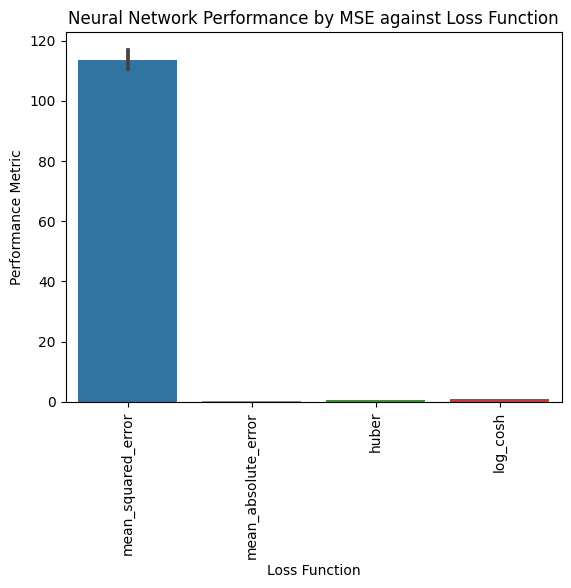

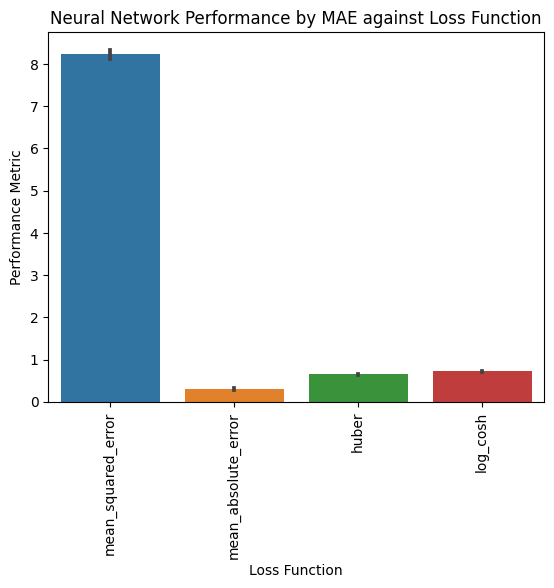

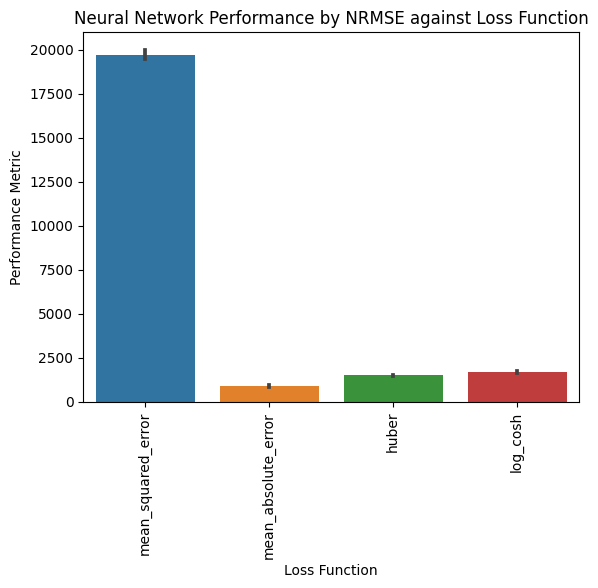

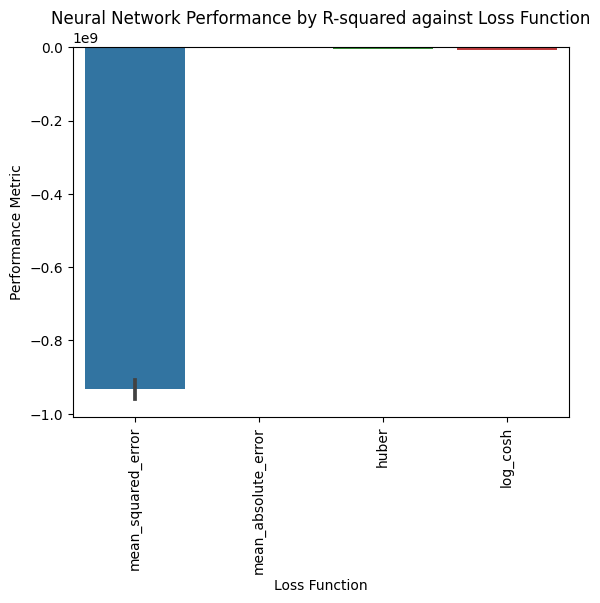

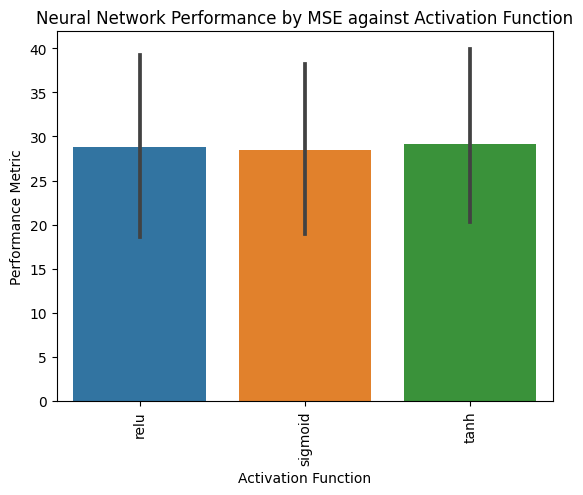

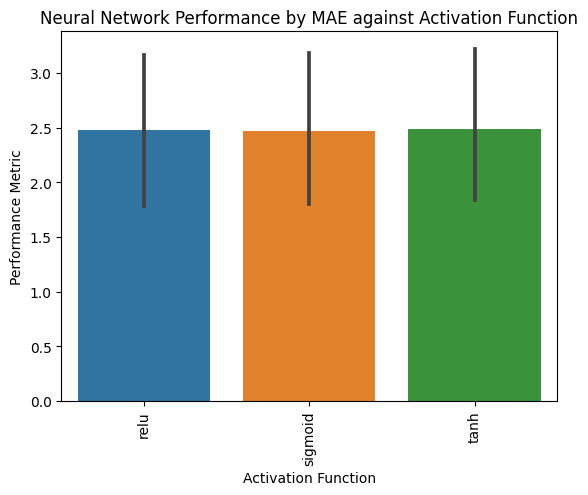

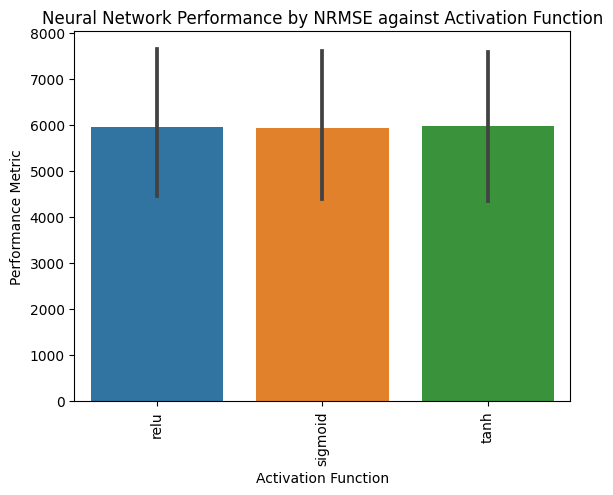

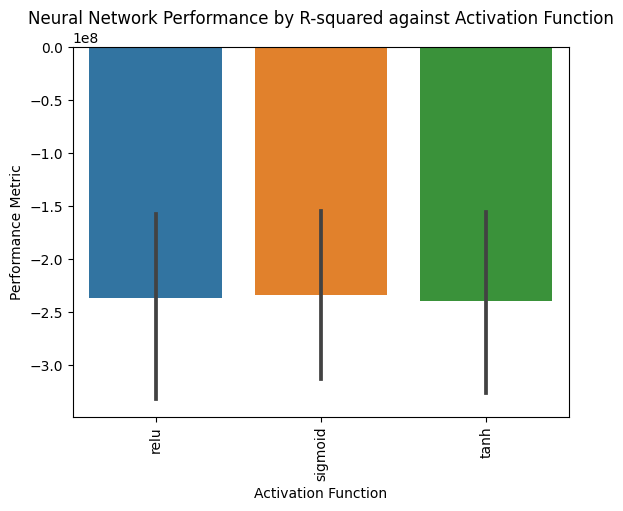

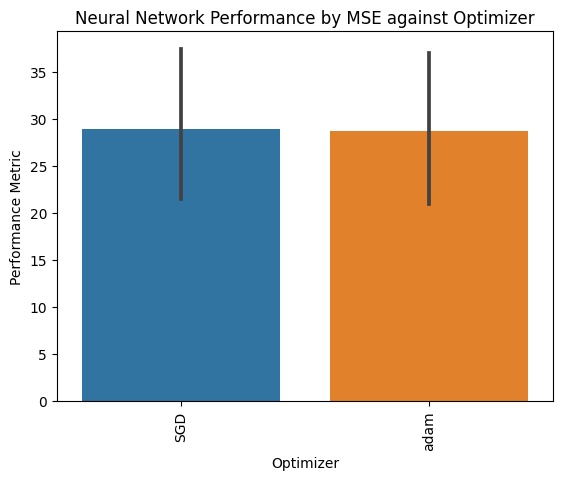

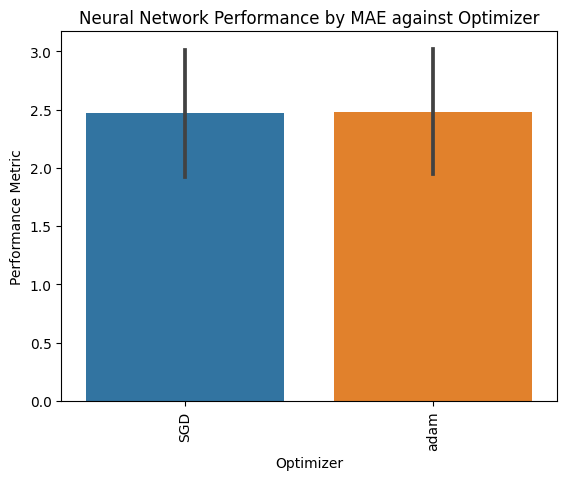

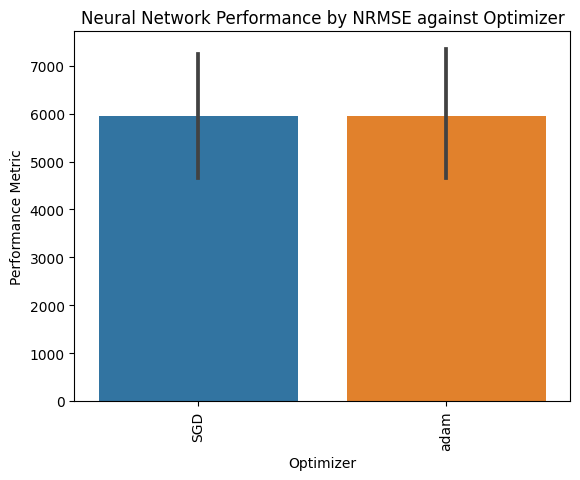

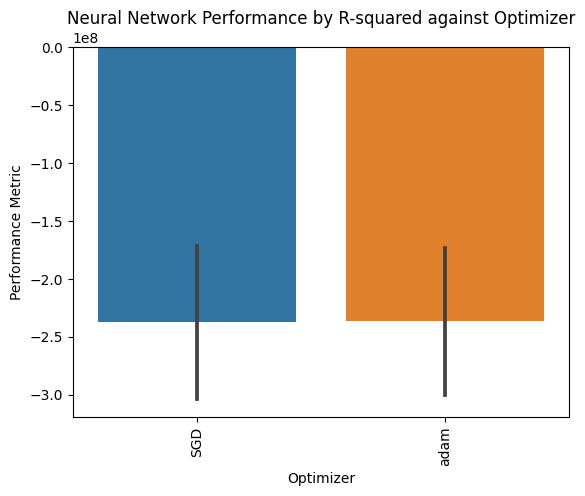

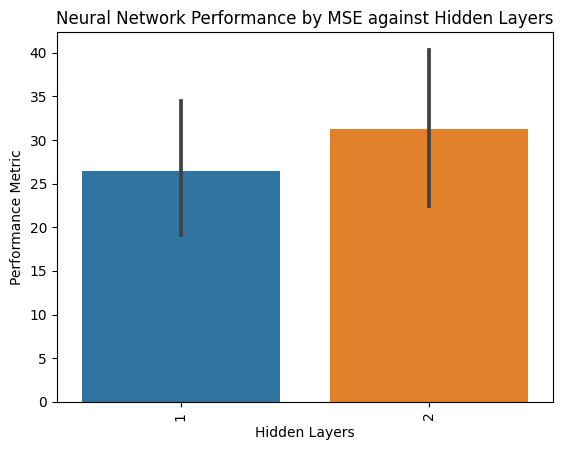

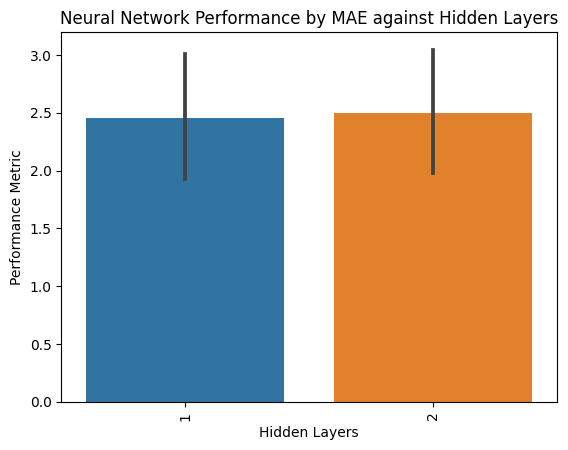

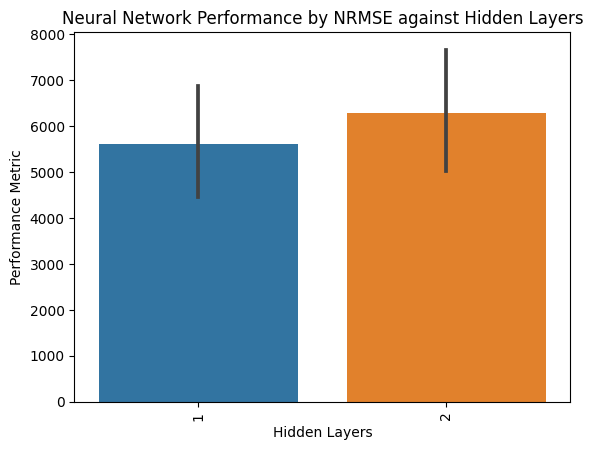

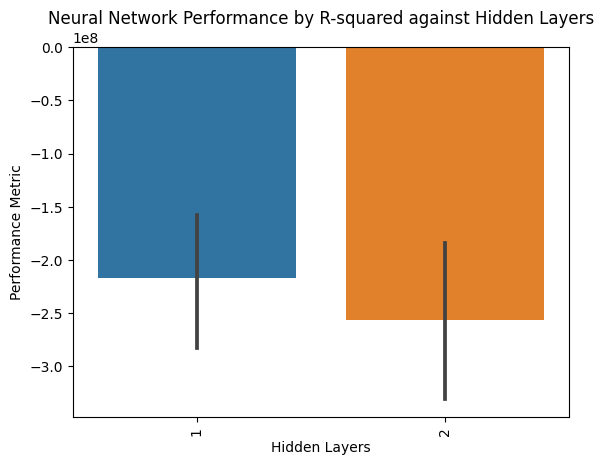

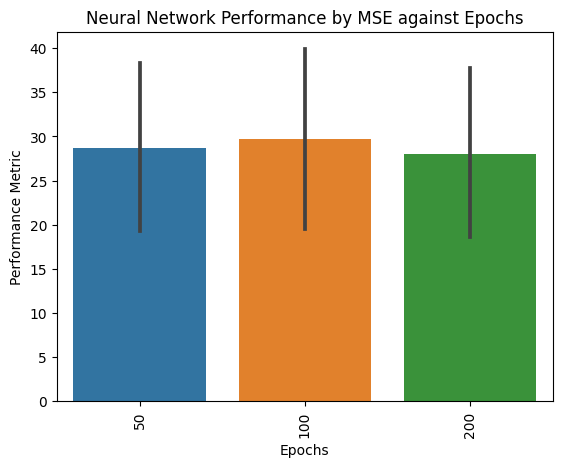

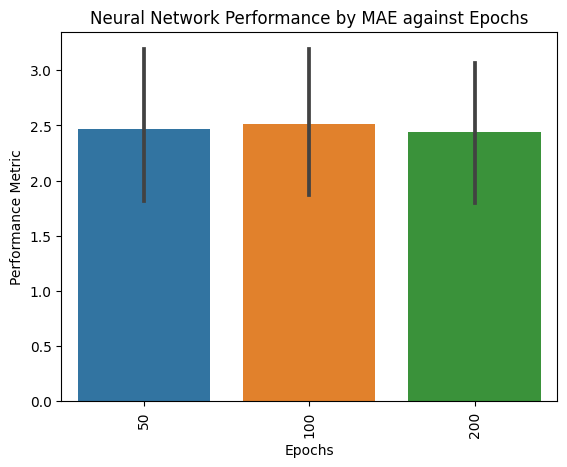

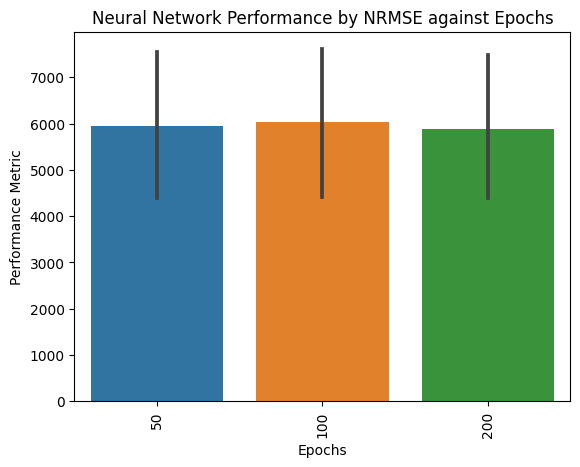

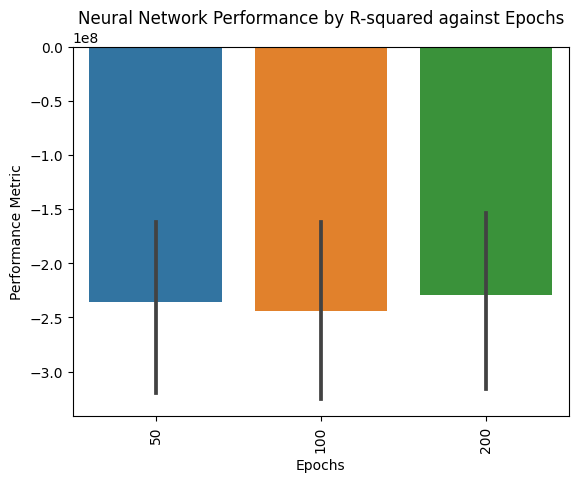

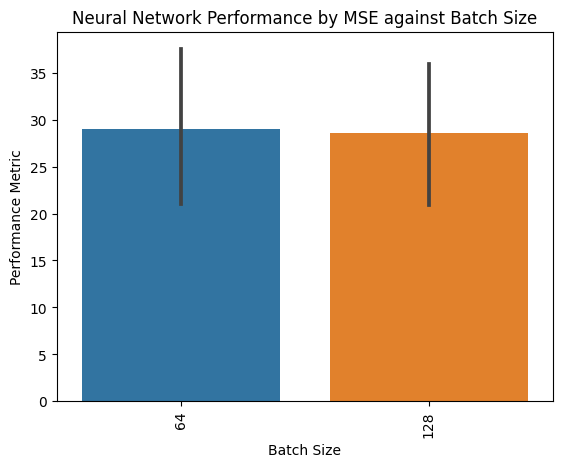

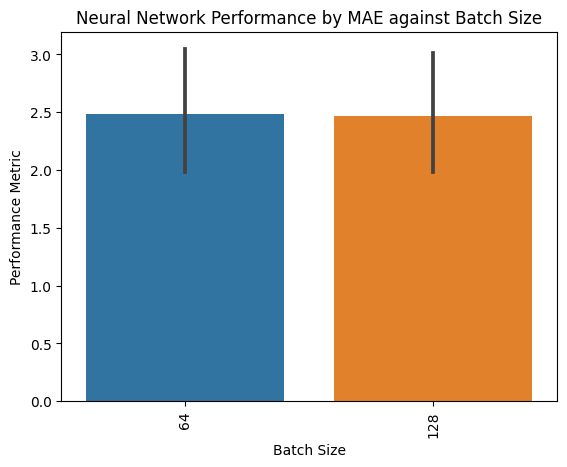

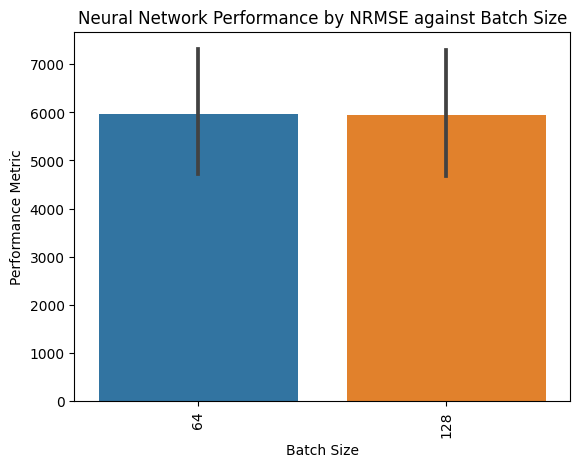

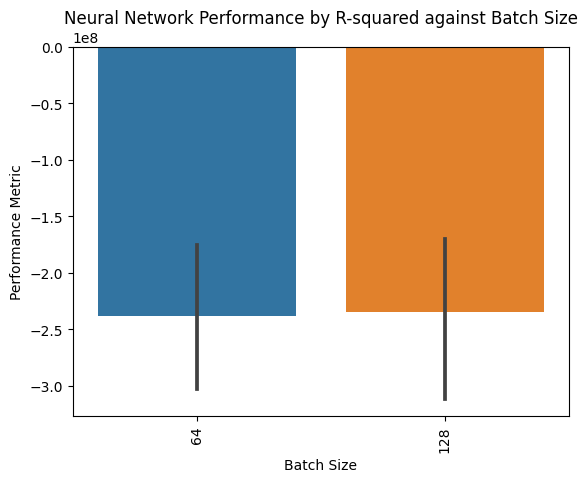

In [53]:
nn_results_injury_rate_df = nn_results_df[nn_results_df["Target"] == "Injury Rate"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_injury_rate_df, x_metric, y_metric)

In [54]:
print_overall_nn_min_stats(nn_results_injury_rate_df, 'Neural Network Injury Rate Performance')

Neural Network Injury Rate Performance
Model                       576
Target                      576
Loss Function               720
Activation Function         576
Optimizer                   576
Hidden Layers               576
Epochs                      576
Batch Size                  576
Neurons per hidden layer    576
MSE                         712
MAE                         712
NRMSE                       712
R-squared                   596
dtype: int64 



In [56]:
nn_results_df.iloc[[712]]

Model       Target        Loss Function Activation Function  \
712  Neural Network  Injury Rate  mean_absolute_error                tanh   

    Optimizer  Hidden Layers  Epochs  Batch Size  Neurons per hidden layer  \
712      adam              1     200          64                        32   

         MSE      MAE       NRMSE      R-squared  
712  0.08789  0.20258  549.445417 -721756.533595

### Predicting average injury cost

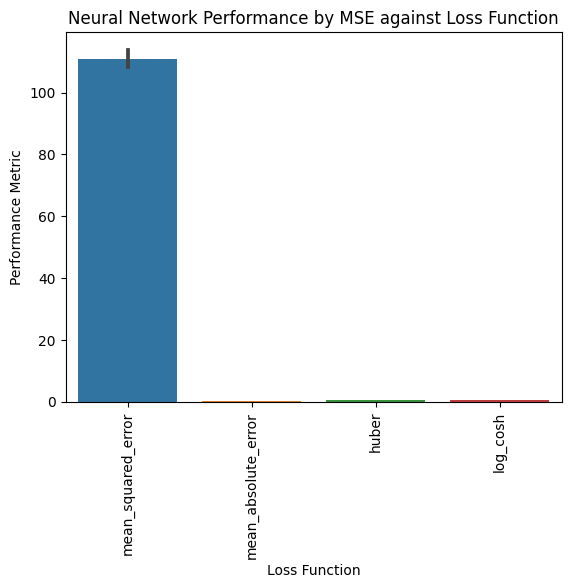

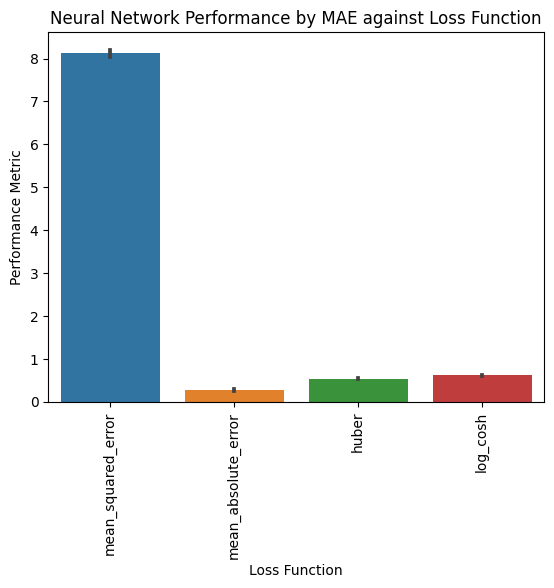

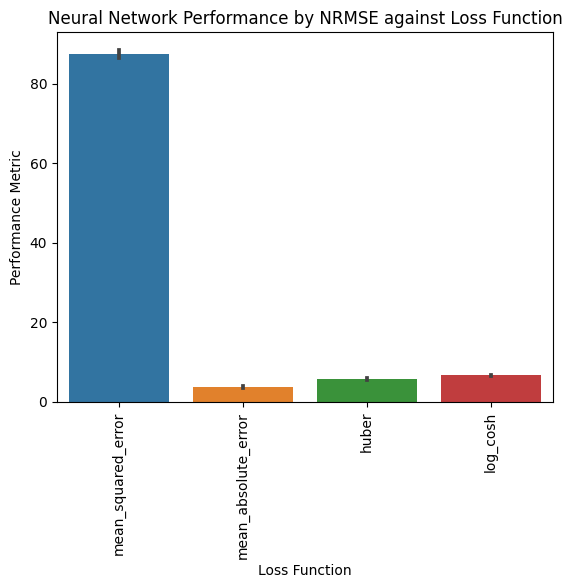

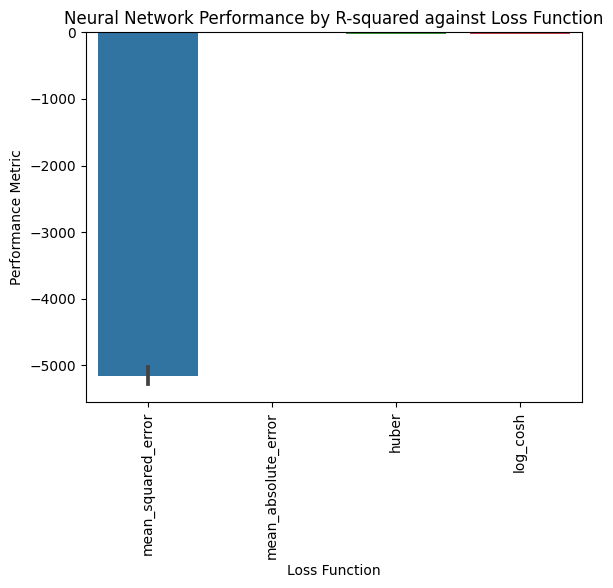

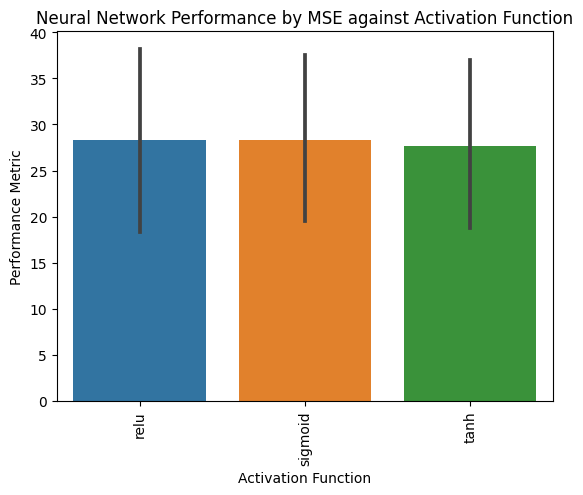

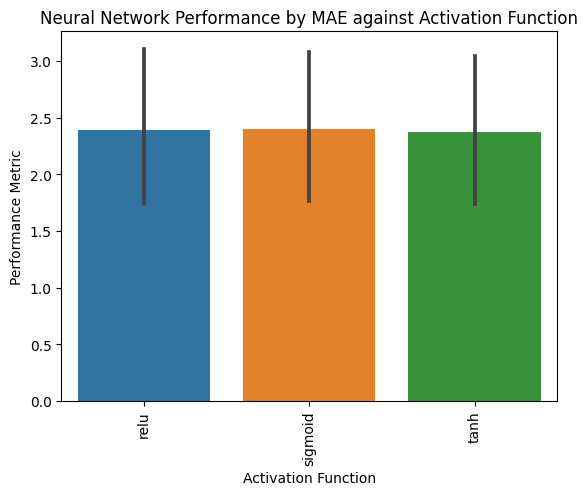

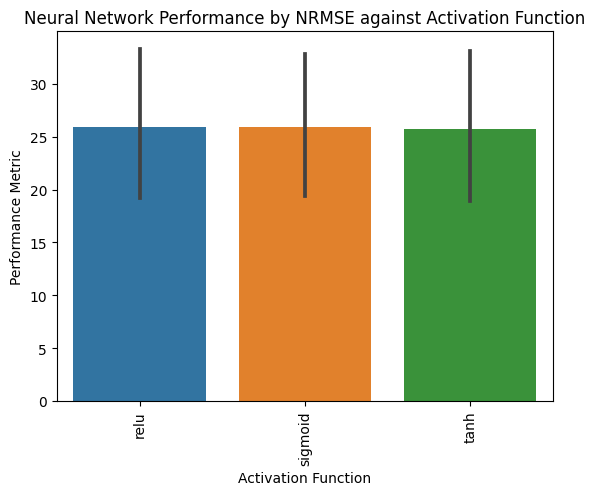

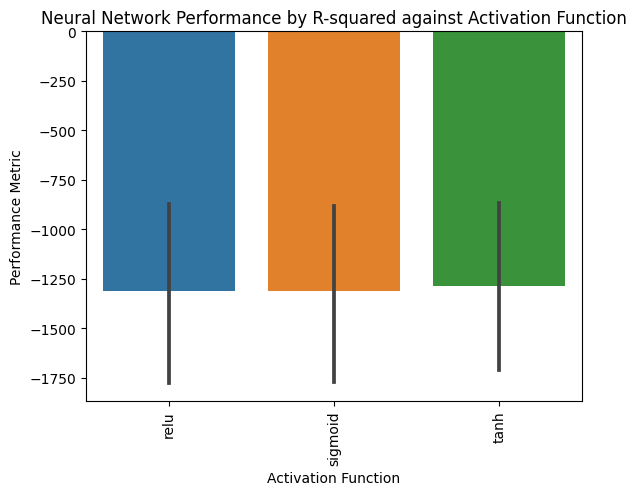

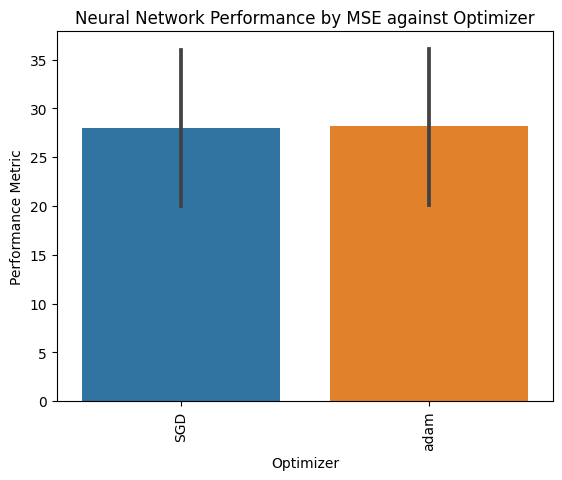

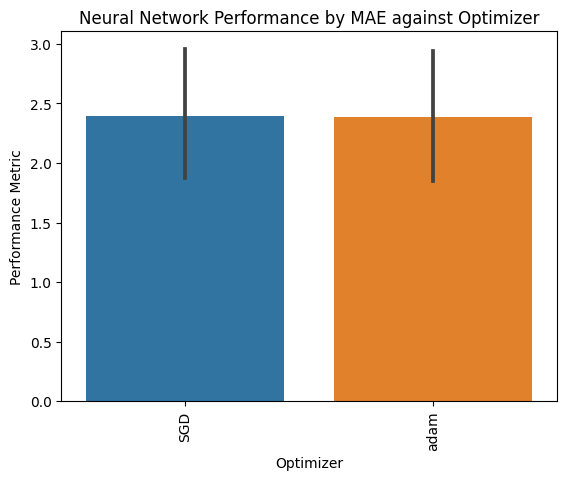

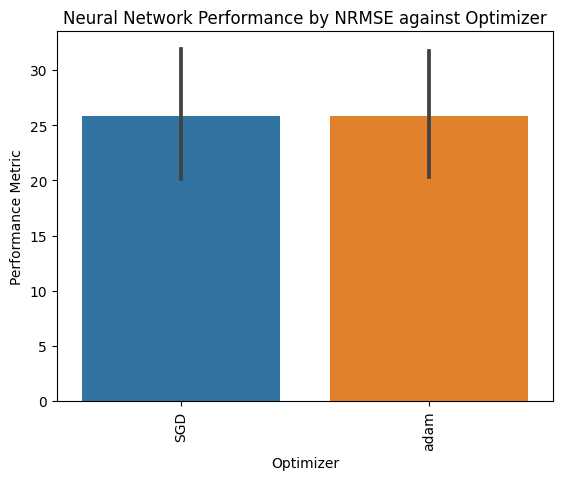

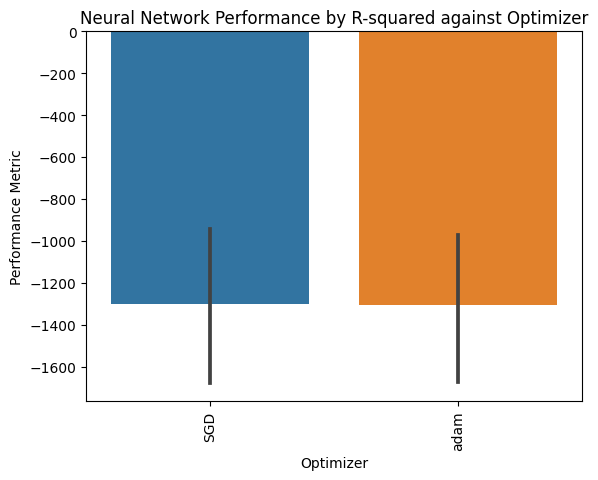

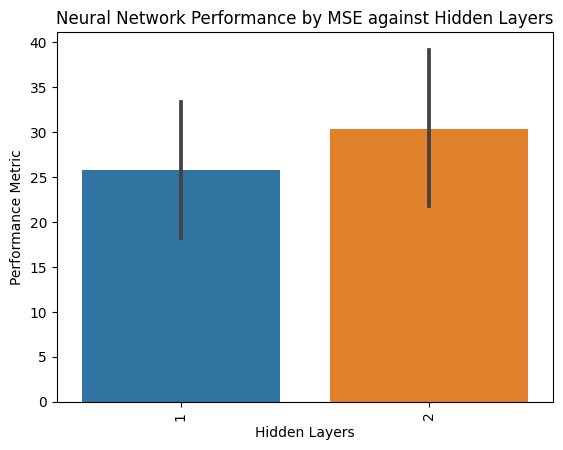

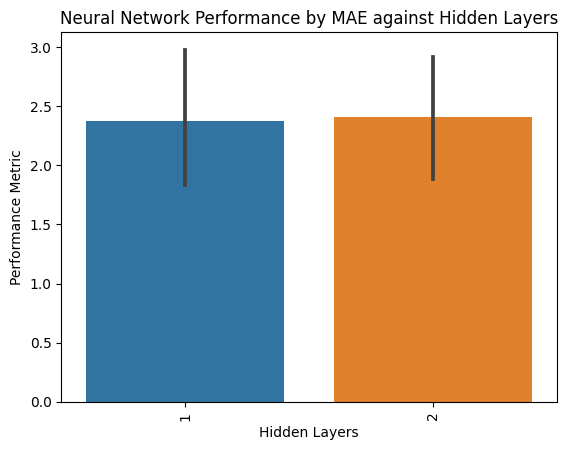

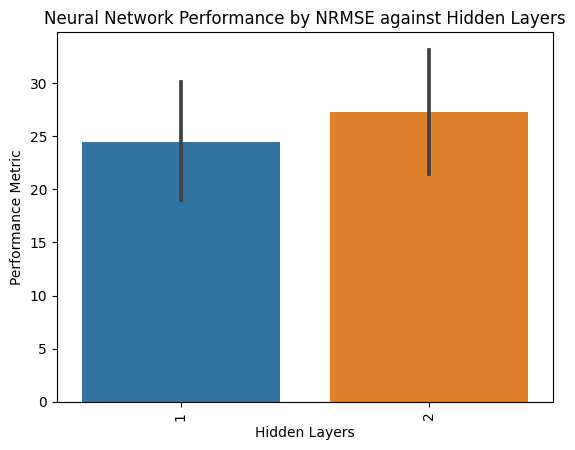

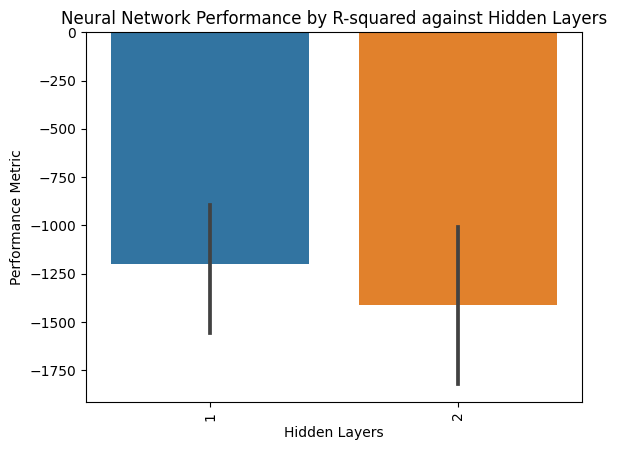

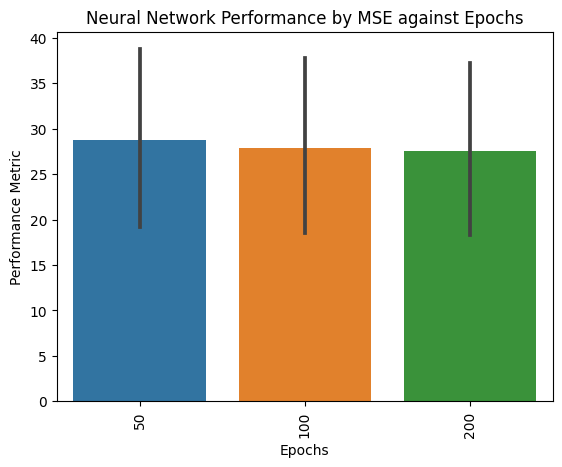

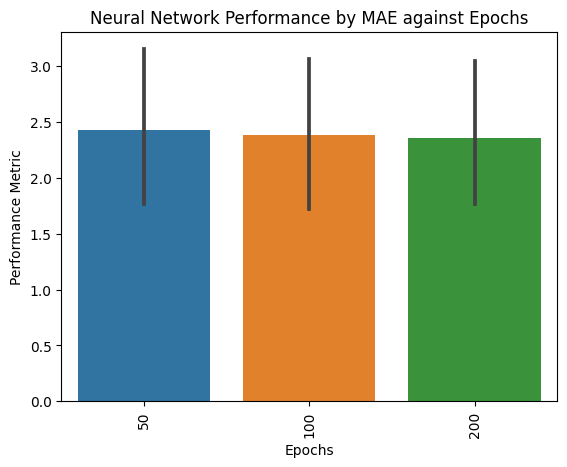

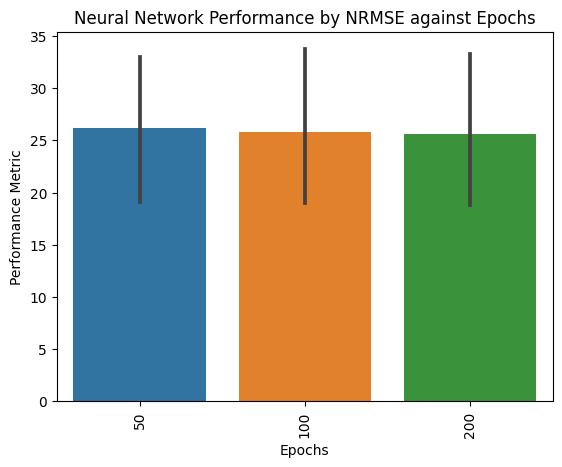

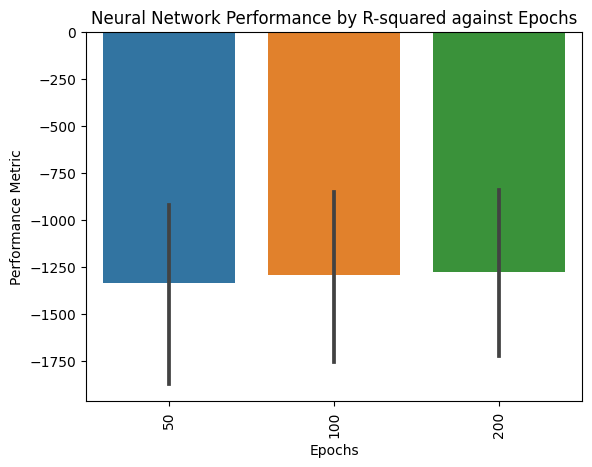

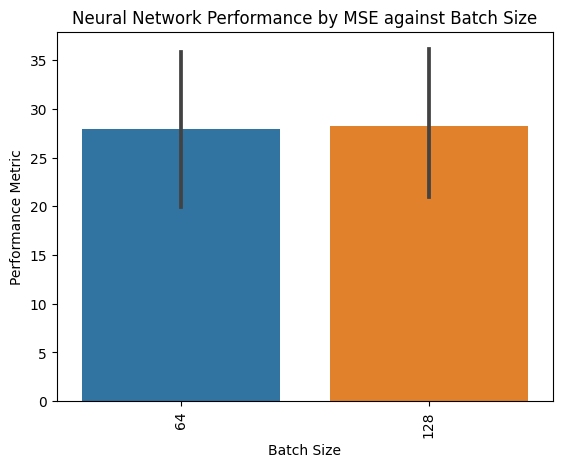

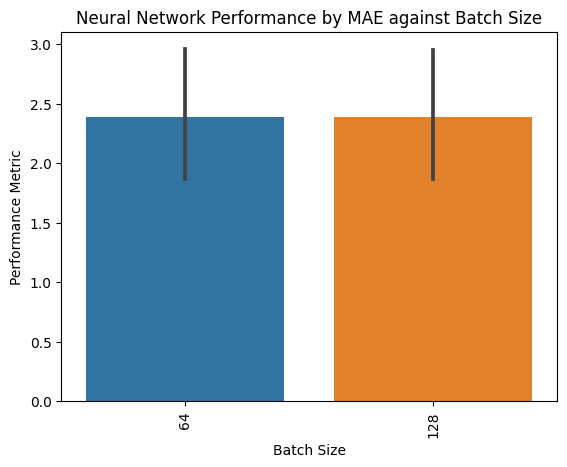

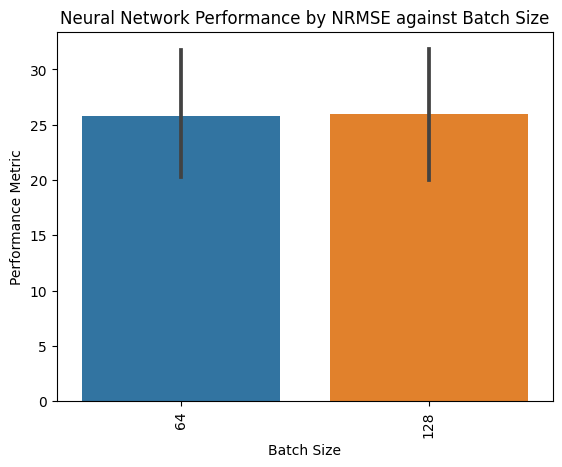

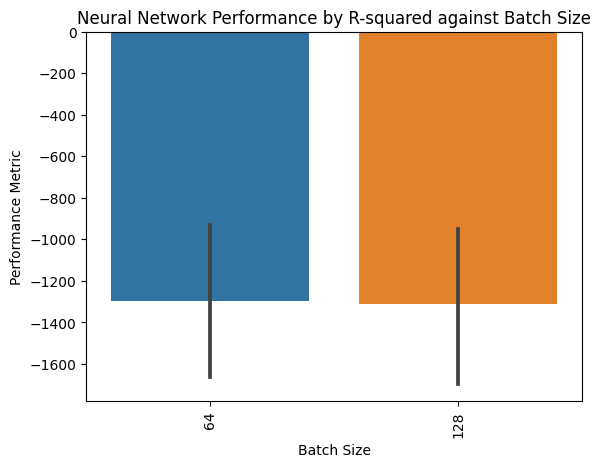

In [57]:
nn_results_avg_injury_cost_df = nn_results_df[nn_results_df["Target"] == "Average Injury Cost"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_avg_injury_cost_df, x_metric, y_metric)

In [58]:
print_overall_nn_min_stats(nn_results_avg_injury_cost_df, 'Neural Network Average Injury Cost Performance')

Neural Network Average Injury Cost Performance
Model                       288
Target                      288
Loss Function               432
Activation Function         288
Optimizer                   288
Hidden Layers               288
Epochs                      288
Batch Size                  288
Neurons per hidden layer    288
MSE                         424
MAE                         397
NRMSE                       424
R-squared                   320
dtype: int64 



In [60]:
nn_results_df.iloc[[424]]

Model               Target        Loss Function  \
424  Neural Network  Average Injury Cost  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
424                tanh      adam              1     200          64   

     Neurons per hidden layer       MSE       MAE     NRMSE  R-squared  
424                        32  0.069568  0.182621  2.191213  -2.229842

# Comparing the performance of different models
Now that we have several models, we can compare the performance of these models by plotting a graph of Evaluation Metrics against Model, for each target that we are trying to predict.

In [61]:
eval_metrics_df = pd.DataFrame(evaluation_metrics)
eval_metrics_df.to_csv('model_performance.csv', index = False)

In [62]:
def plot_model_comparison(df, x, target):
    """
    Plots the performance of different models for a specific target variable.

    Args:
    df: DataFrame containing model performance metrics.
    target: Target variable to focus on.
    """

    # Filter data for the specified target
    target_df = df[df['Target'] == target]

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y='Model', data=target_df, orient='h')
    plt.title(f'Model Performance by {target}')
    plt.xlabel(f'{x}')
    plt.ylabel('Model')
    plt.show()


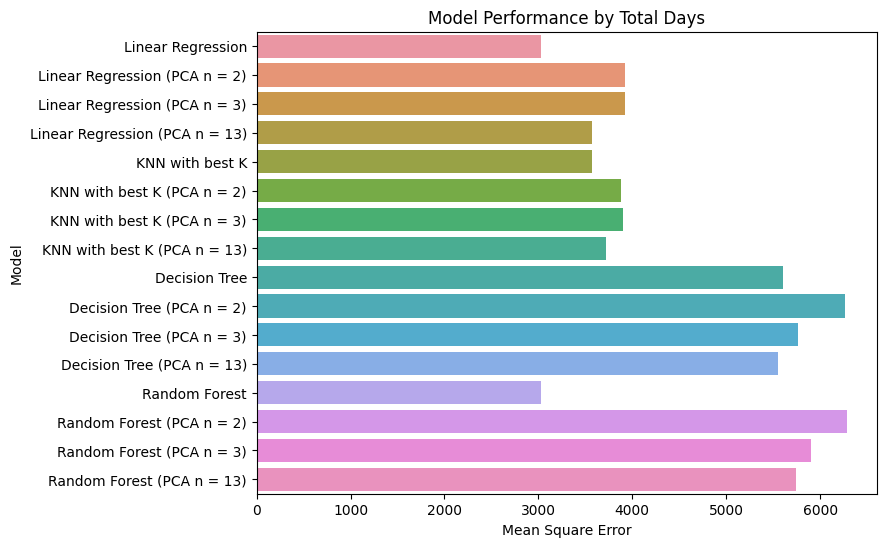

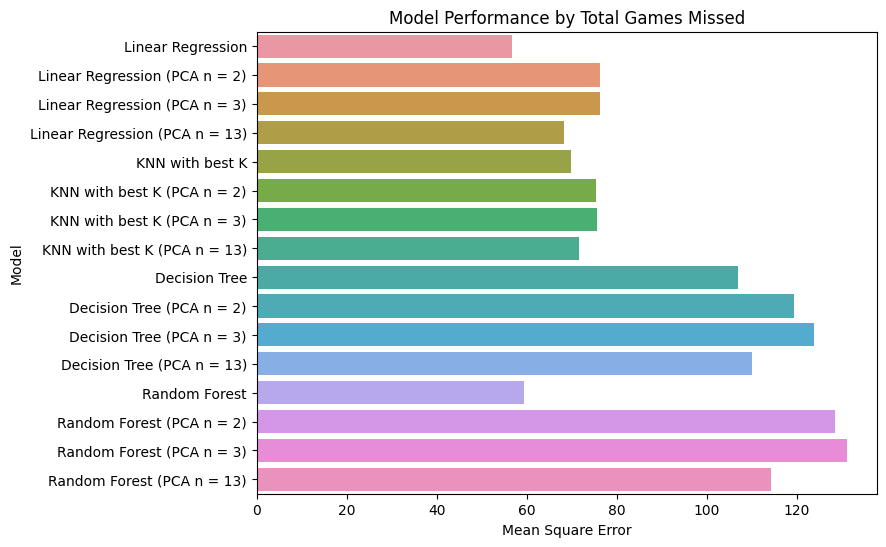

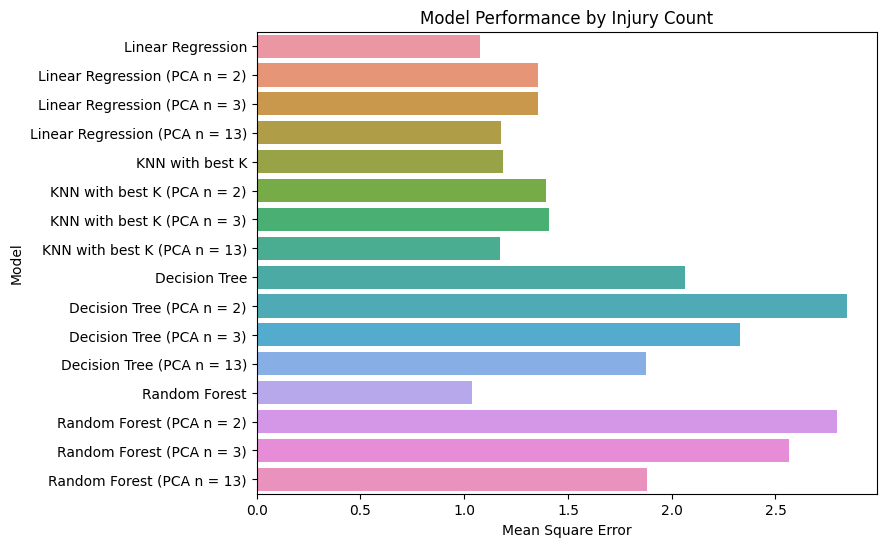

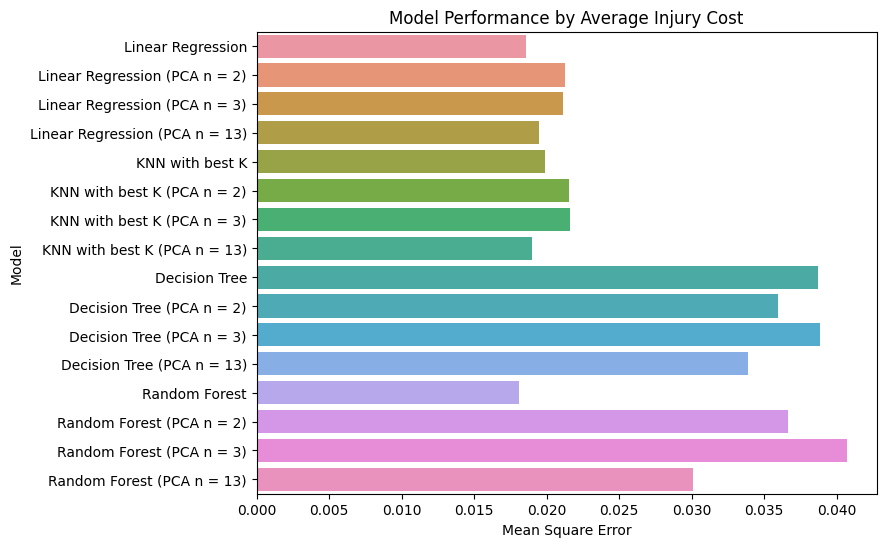

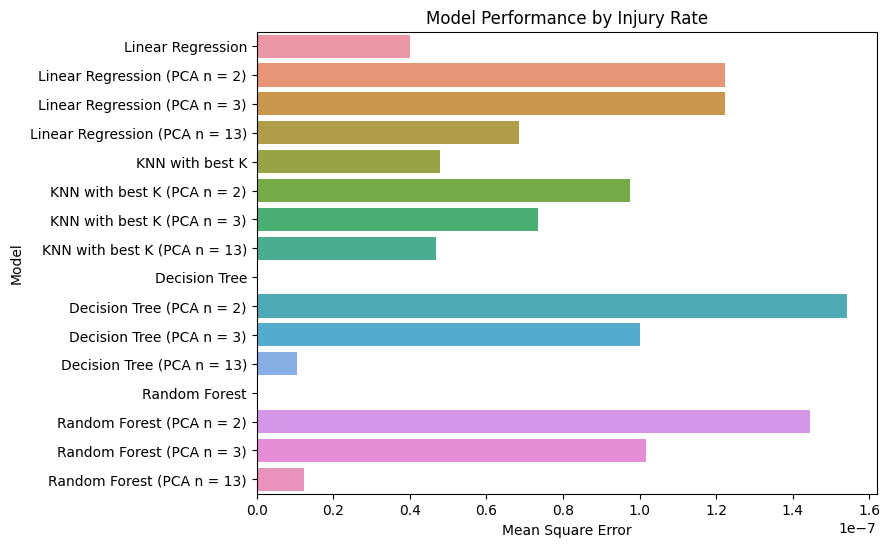

In [63]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Mean Square Error', target)

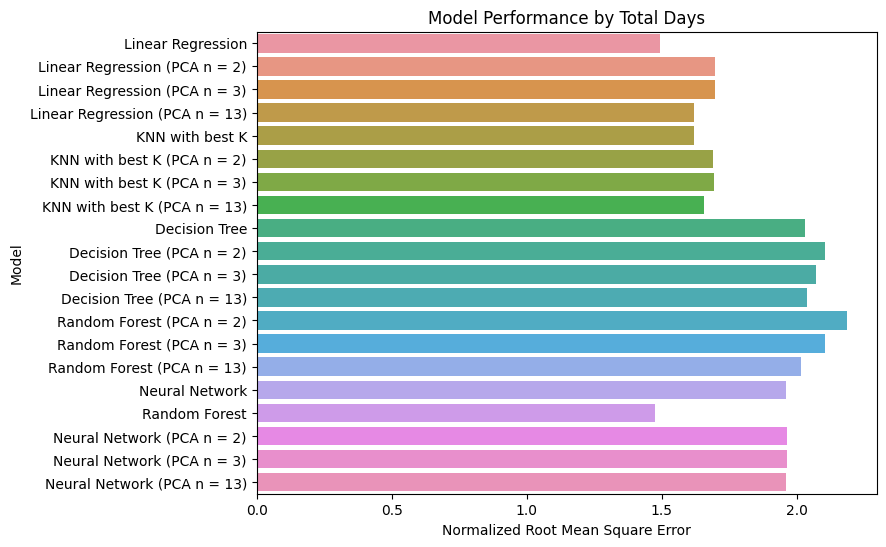

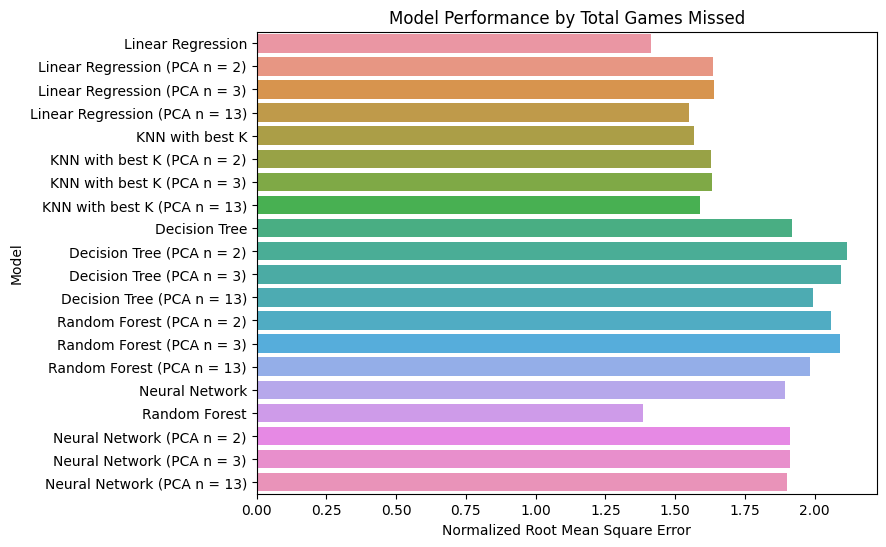

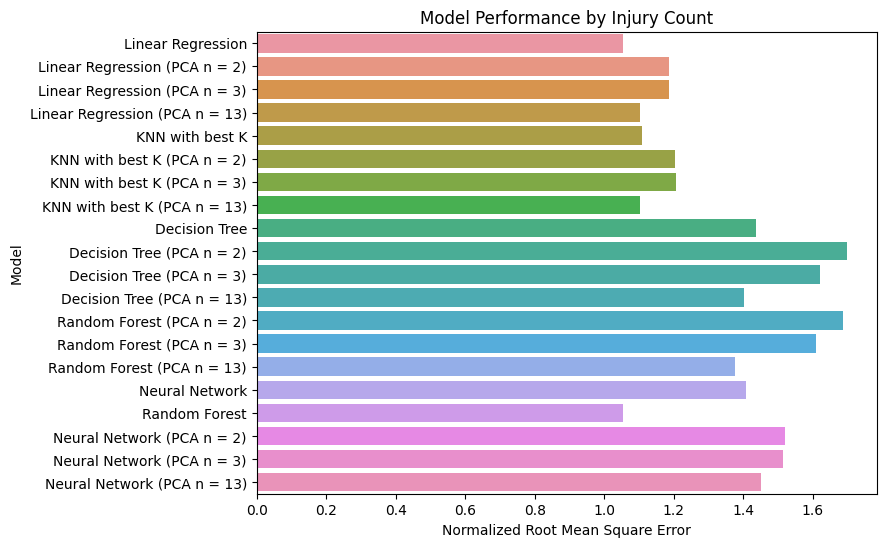

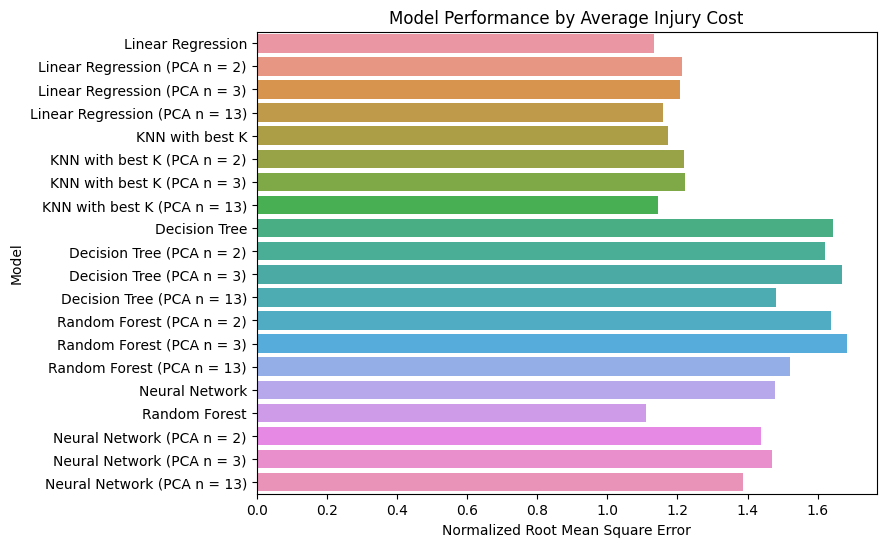

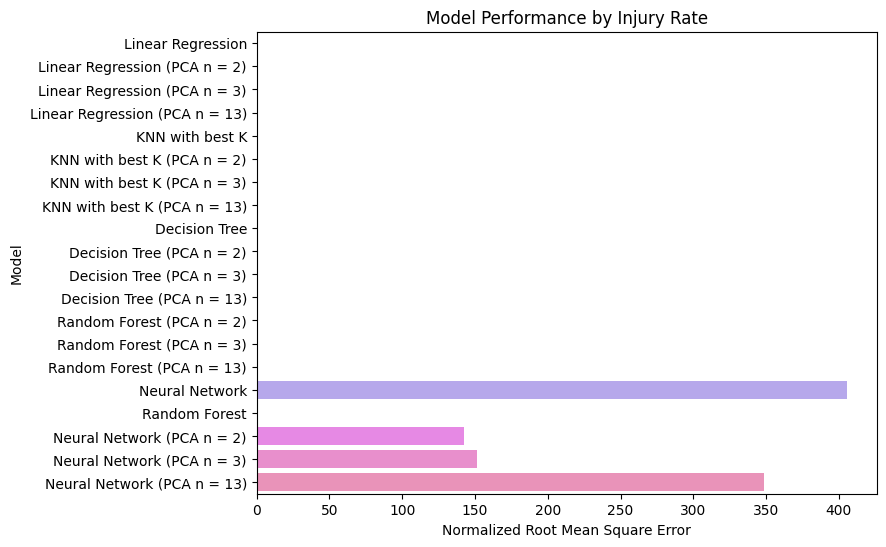

In [58]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Normalized Root Mean Square Error', target)

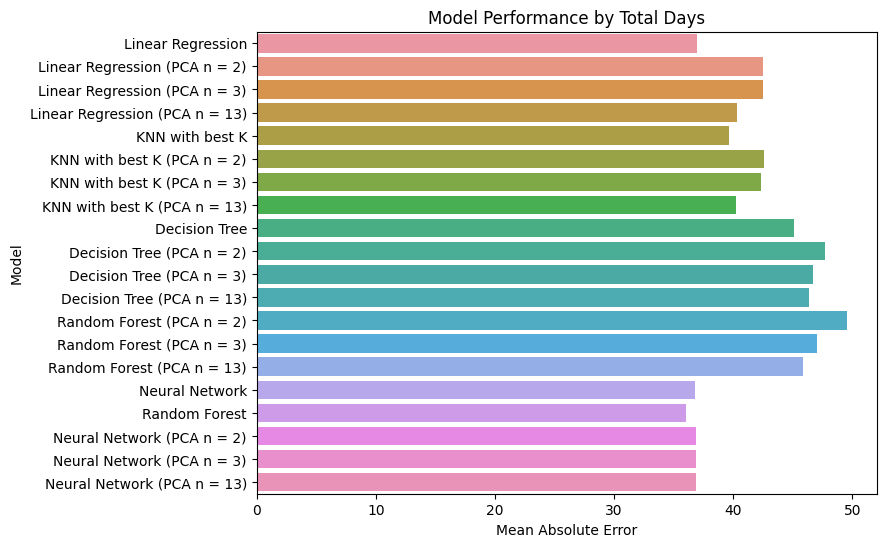

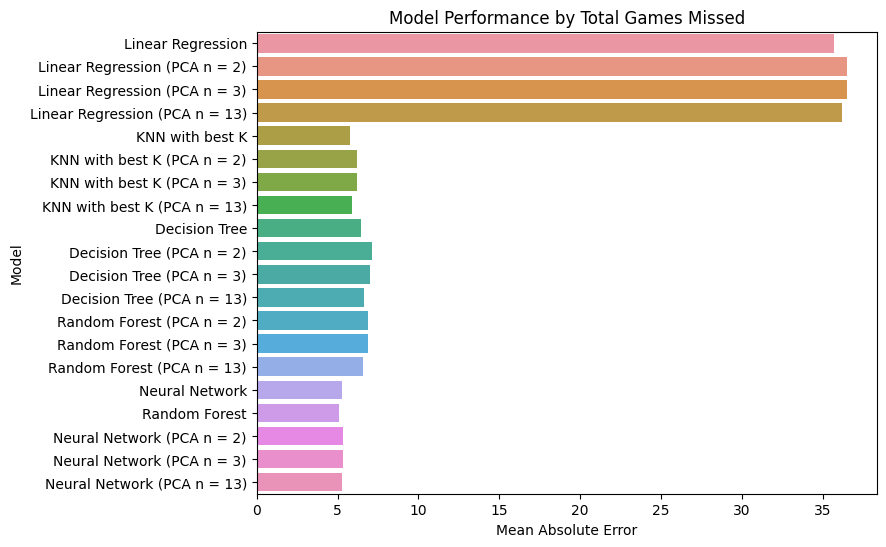

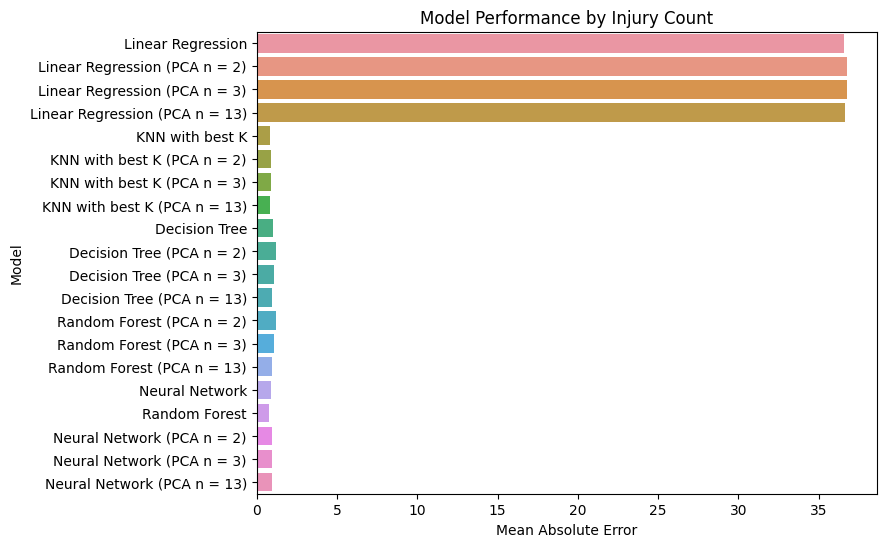

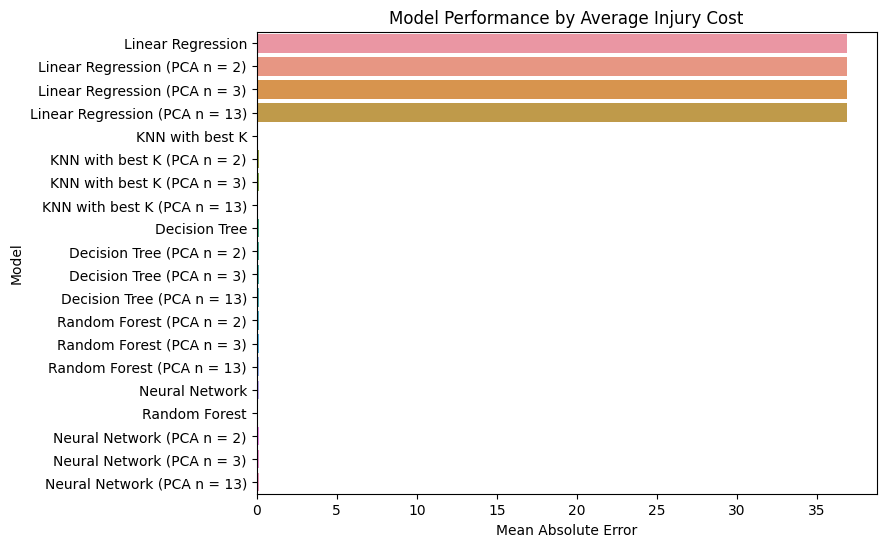

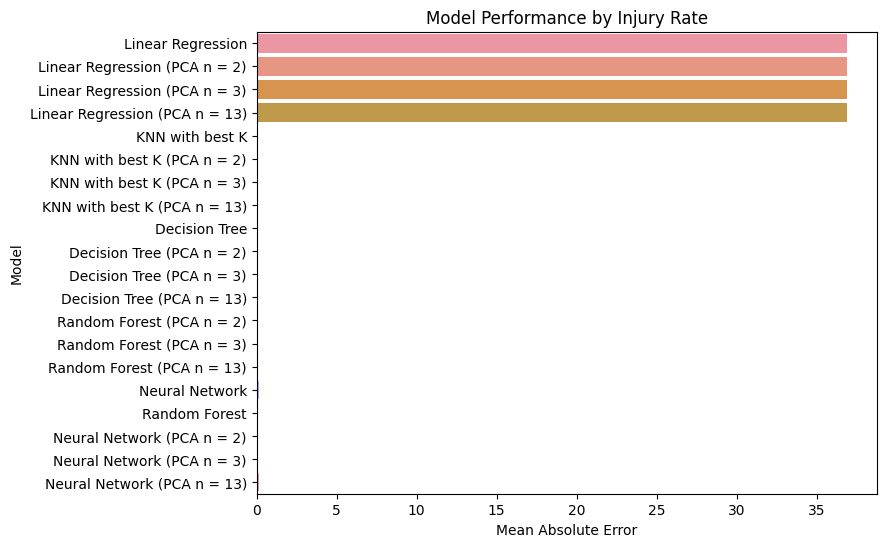

In [63]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Mean Absolute Error', target)

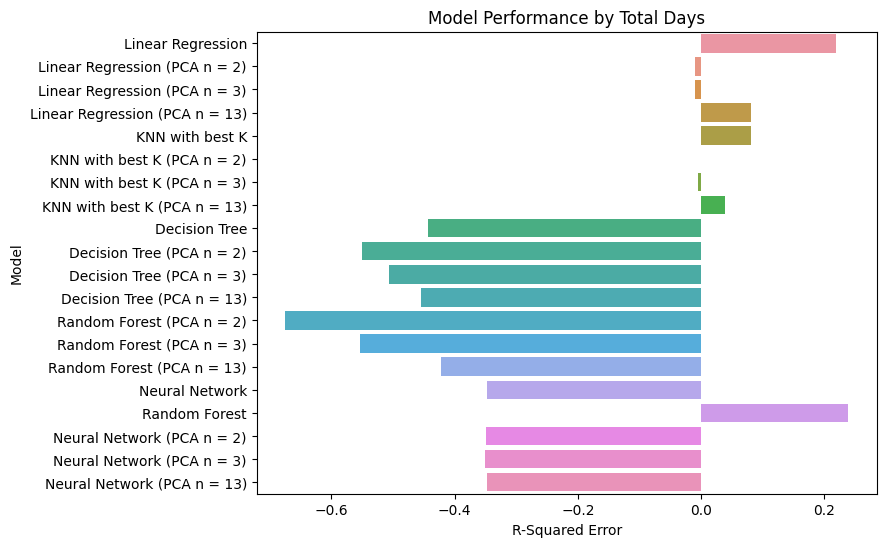

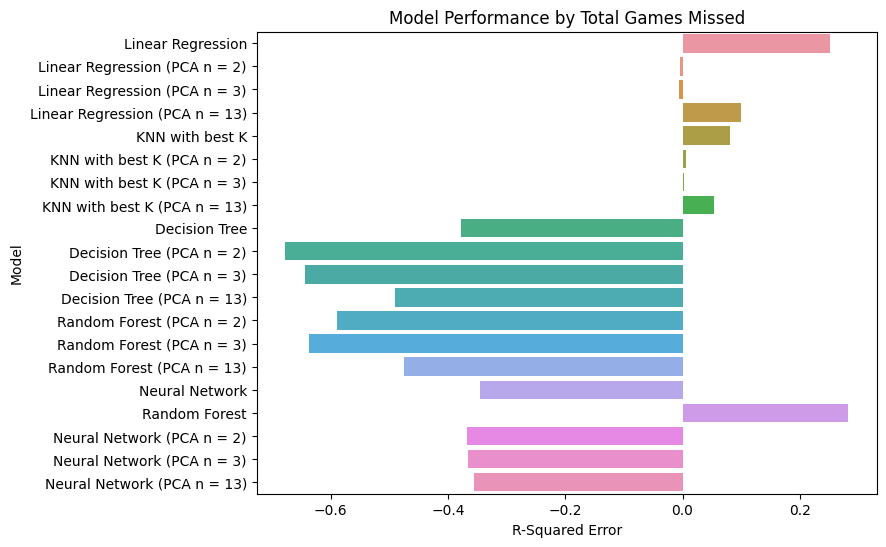

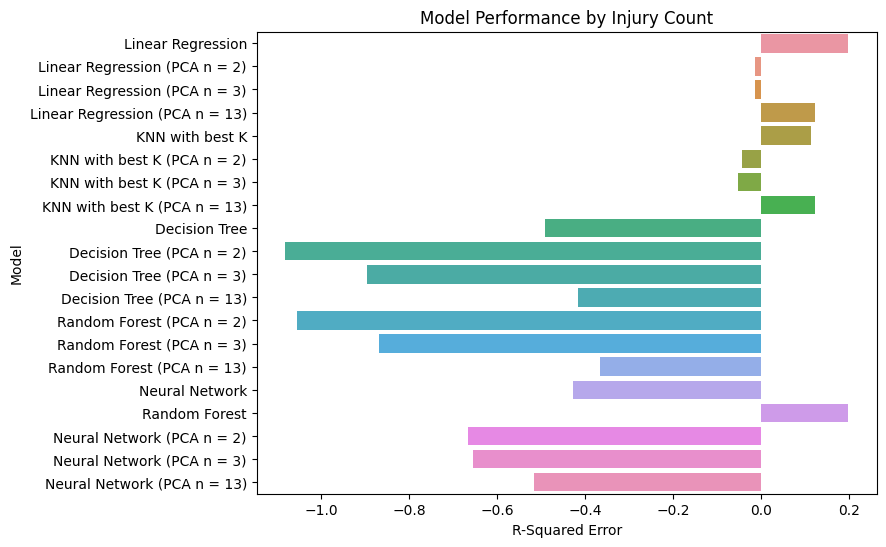

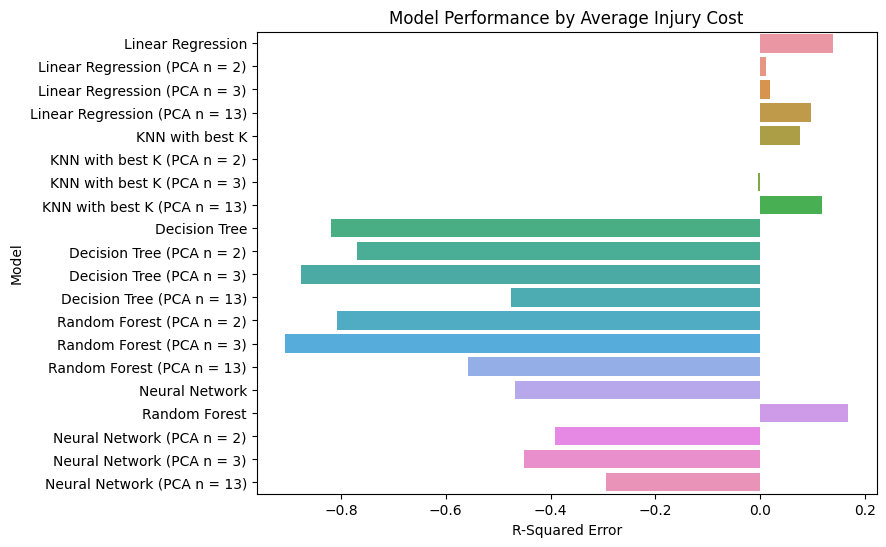

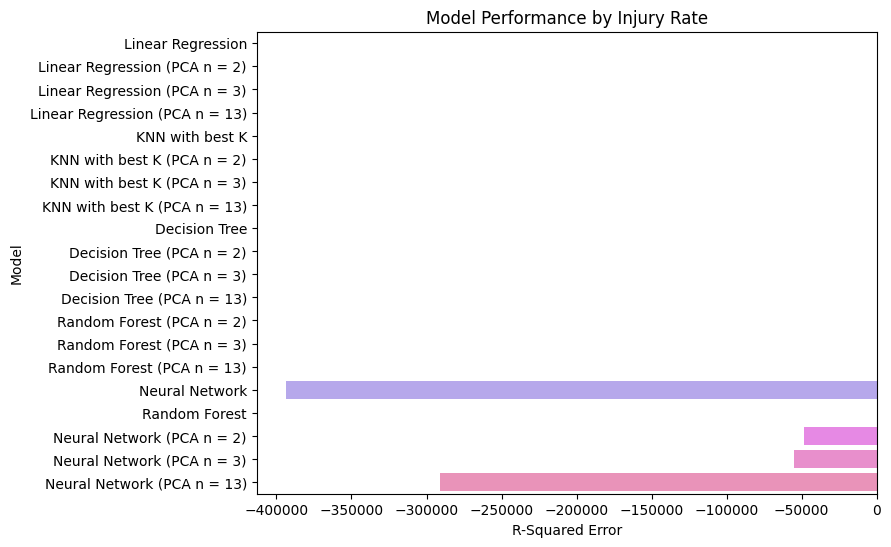

In [64]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'R-Squared Error', target)